## Fastmarch ORCA Policy

In [1]:
import numpy as np
from crowd_sim.envs.policy.orca import ORCA
from crowd_sim.envs.utils.state import JointState
import CMap2D
import matplotlib.pyplot as plt
from map2d import gridshow

class Suicide(object):
    def __init__(self):
        pass

class FastmarchORCAPolicy(object):
    def __init__(self, suicide_if_stuck=False):
        self.simulator = ORCA()
        self.suicide_if_stuck = suicide_if_stuck
        self.map = CMap2D.CMap2D()
        self.grid_num = 100
        self.new = True

    def reset(self):
        self.new = True
        self.simulator.reset()        
    
    def predict(self, obs, env):
        self.simulator.time_step = env._get_dt()
        other_agent_states = [
            agent.get_observable_state() for agent in env.soadrl_sim.humans + env.soadrl_sim.other_robots]
        joint_state = JointState(env.soadrl_sim.robot.get_full_state(), other_agent_states)
        
        if self.new:
            #find an appropriate origin
            bbox = env.soadrl_sim.obstacle_vertices[-1]
            bbox_ll = np.array(bbox[-1])
            bbox_tr = np.array(bbox[1])
            self.map.origin[0] = bbox_ll[0] - 0.25
            self.map.origin[1] = bbox_ll[1] - 0.25
            
            #find the right resolution
            max_dim = max(bbox_tr-bbox_ll)
            #offset = 2*max_dim/self.grid_num
            self.map.set_resolution((max_dim+2*0.25)/self.grid_num)
            
            #initialise occupancy
            self.map._occupancy = np.ones((self.grid_num,self.grid_num), dtype = np.float32)
            bbox_ij = self.map.xy_to_ij(bbox)
            self.map._occupancy[bbox_ij[-1,0]:bbox_ij[1,0], bbox_ij[-1,1]:bbox_ij[1,1]] = 0
            
            radius = env.soadrl_sim.robot.radius*1.05
            for vertex in env.soadrl_sim.obstacle_vertices[:-1]:
                xy_min, xy_max = np.min(vertex, 0), np.max(vertex,0)
                xy_min -= radius
                xy_max += radius
                min_max_ij = self.map.xy_to_ij([xy_min,xy_max])
                self.map._occupancy[min_max_ij[0,0]:min_max_ij[1,0], min_max_ij[0,1]:min_max_ij[1,1]] = 1
            #self.map.HUGE_ = 100 * np.prod( self.map._occupancy.shape )
            #calculate the field
            goal = self.map.xy_to_ij([(env.soadrl_sim.robot.gx,env.soadrl_sim.robot.gy)])
            self.field = self.map.fastmarch(goal[0])
            
            plt.figure("occupancy") 
            grid = self.map.occupancy()
            gridshow(self.field)
            
            self.new = False
        
            # only for vizualisation atm
            robot_pos_xy = (joint_state.self_state.px, joint_state.self_state.py)
            robot_pos_ij = self.map.xy_to_ij([robot_pos_xy])
            gridfmpath8, jumps = CMap2D.path_from_dijkstra_field(self.field, robot_pos_ij[0], connectedness= 8)
            plt.plot(gridfmpath8[:,0],  gridfmpath8[:,1] , '-o', color=plt.cm.winter(0.33) , mec=plt.cm.winter(0.33), mfc=[0,0,0,0])
            plt.show()
        robot_pos_xy = (joint_state.self_state.px, joint_state.self_state.py)
        robot_pos_ij = self.map.xy_to_ij([robot_pos_xy])
        gridfmpath8, jumps = CMap2D.path_from_dijkstra_field(self.field, robot_pos_ij[0], connectedness= 8) 
        
        if gridfmpath8.shape[0] > 15:
            virtual_goal = gridfmpath8[15]  # look forward in path
            virtual_goal[0] = (virtual_goal[0]*self.map.resolution())+self.map.origin[0]
            virtual_goal[1] = (virtual_goal[1]*self.map.resolution())+self.map.origin[1]
            print("vx: ", joint_state.self_state.vx,"vy: ", joint_state.self_state.vy, "v: ",
                  np.sqrt(joint_state.self_state.vx**2+joint_state.self_state.vy**2))
            joint_state.self_state.gx = virtual_goal[0]
            joint_state.self_state.gy = virtual_goal[1]
            
            if np.sqrt(joint_state.self_state.vx**2+joint_state.self_state.vy**2) < 0.25:
                virtual_goal = gridfmpath8[8]  # look forward in path
                virtual_goal[0] = (virtual_goal[0]*self.map.resolution())+self.map.origin[0]
                virtual_goal[1] = (virtual_goal[1]*self.map.resolution())+self.map.origin[1]
                idx = np.argmin([virtual_goal[0] - robot_pos_xy[0],virtual_goal[0] - robot_pos_xy[0]])
                print("idx: ", idx)
                if idx == 0:
                    joint_state.self_state.gx = robot_pos_xy[0] + np.sign(virtual_goal[0] - robot_pos_xy[0])#*(virtual_goal[1] - robot_pos_xy[1]) #virtual_goal[0]
                elif idx == 1:
                    joint_state.self_state.gy = robot_pos_xy[1] + np.sign(virtual_goal[1] - robot_pos_xy[1])#*(virtual_goal[0] - robot_pos_xy[0]) #virtual_goal[1]
            
        action = self.simulator.predict(
            joint_state,
            env.soadrl_sim.obstacle_vertices,
            env.soadrl_sim.robot,
        )
        if self.suicide_if_stuck:
            if action.v < 0.02:
                return Suicide()
        vx = action.v * np.cos(action.r)
        vy = action.v * np.sin(action.r)
        return np.array([vx, vy]) #, 0.1*(np.random.random()-0.5)

/home/mads/miniconda3/envs/NavRepEnv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mads/miniconda3/envs/NavRepEnv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mads/miniconda3/envs/NavRepEnv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mads/miniconda3/envs/NavRepEnv/lib

## Play Policy

In [2]:
import os

def play_policy(env, n_sequences, episode_length=1000,
                         subset_index=0, n_subsets=1,
                         render=True,
                         policy=FastmarchORCAPolicy(),
                         archive_dir=os.path.expanduser("~/navrep/datasets/V/ian")
                         ):
    """
    if n_subsets is None, the whole set of sequences is generated (n_sequences)
    if n_subsets is a number > 1, this function only generates a portion of the sequences
    """
    indices = np.arange(n_sequences)
    if n_subsets > 1:  # when multiprocessing
        indices = np.array_split(indices, n_subsets)[subset_index]
    scans = []
    robotstates = []
    actions = []
    rewards = []
    dones = []
    for n in indices:
        policy.reset()
        obs = env.reset()
        for i in range(episode_length):
            # step
            action = policy.predict(obs, env)
            if isinstance(action, Suicide):
                obs = env.reset()
                rew = 0
                action = np.array([0, 0, 0])
                done = True
            else:
                obs, rew, done, _ = env.step(action)
            scans.append(obs[0])
            robotstates.append(obs[1])
            actions.append(action)
            rewards.append(rew)
            dones.append(done)
            if render:
                env.render()
            if done:
                policy.reset()
                obs = env.reset()
        dones[-1] = True

    scans = np.array(scans)
    robotstates = np.array(robotstates)
    actions = np.array(actions)
    rewards = np.array(rewards)
    dones = np.array(dones)
    data = dict(scans=scans, robotstates=robotstates, actions=actions, rewards=rewards, dones=dones)
        #if archive_dir is not None:
         #   make_dir_if_not_exists(archive_dir)
          #  archive_path = os.path.join(
           #     archive_dir, "{:03}_scans_robotstates_actions_rewards_dones.npz".format(n)
            #)
            #np.savez_compressed(archive_path, **data)
            #print(archive_path, "written.")
    env.close()
    return data

Ros was not found, disabled.


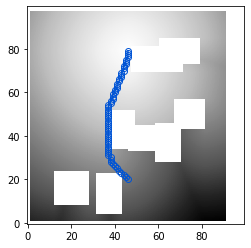

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -0.1446095705032348 vy:  0.6055678129196167 v:  0.6225948152092
vx:  -0.2529031038284302 vy:  0.582589864730835 v:  0.6351148954426642
vx:  -0.37653088569641113 vy:  0.6060762405395508 v:  0.7135151836014979
vx:  -0.4384242594242096 vy:  0.8697669506072998 v:  0.9740176485158715
vx:  -0.4370600879192351 vy:  0.8670604825019836 v:  0.9709868180199679
vx:  -0.43545234203338634 vy:  0.8638709783554075 v:  0.9674150140591629
vx:  -0.43354237079620367 vy:  0.860081911087036 v:  0.9631717816956231
vx:  -0.4248718023300172 vy:  0.8428807258605956 v:  0.9439088761328827
vx:  -0.42226386070251454 vy:  0.8377071022987366 v:  0.9381151087671163
vx:  -0.4192657470703126 vy:  0.8317593336105346 v:  0.9314544302941866
vx:  -0.4158041179180145 vy:  0.8248920440673827 v:  0.9237640114462367
vx:  -0.4117902517318726 vy:  0.816929042339325 v:  0.9148465836624442
vx:  -0.40711736679077154 vy:  0.8076587915420532 v:  0.9044651866699024
vx:  -0.4017324447631838 vy:  0

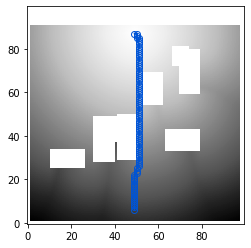

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -0.00558117963373661 vy:  0.8416926860809326 v:  0.8417111899982318
vx:  0.0002878938103094697 vy:  0.9882423281669617 v:  0.9882423701014356
vx:  0.0002878938103094697 vy:  0.9882423281669617 v:  0.9882423701014356
vx:  0.0002913177013397772 vy:  0.9688258171081543 v:  0.9688258609065336
vx:  0.00029076635837560483 vy:  0.9300729036331178 v:  0.9300729490838953
vx:  0.00021807849407201596 vy:  0.8928698897361755 v:  0.8928699163684035
vx:  0.0002168715000153698 vy:  0.8571551442146301 v:  0.8571551716502974
vx:  0.00021520256996143683 vy:  0.8228689432144165 v:  0.8228689713550734
vx:  0.0002130568027496893 vy:  0.7899541854858398 v:  0.7899542142173798
vx:  0.00021040439605718442 vy:  0.7583560347557068 v:  0.7583560639438499
vx:  0.0002072602510452548 vy:  0.7280218005180359 v:  0.7280218300204565
vx:  0.00015377998352048006 vy:  0.6989008784294128 v:  0.6989008953476081
vx:  0.00015144050121312924 vy:  0.67094486951828 v:  0.6709448866092708
v

vx:  -0.09190280735492715 vy:  0.9839598536491393 v:  0.9882424396841862
vx:  -0.09190280735492715 vy:  0.9839598536491393 v:  0.9882424396841862
vx:  -0.06239075586199766 vy:  0.9862709641456604 v:  0.9882423898689238
vx:  -0.06239075586199766 vy:  0.9862709641456604 v:  0.9882423898689238
vx:  -0.06239075586199766 vy:  0.9862709641456604 v:  0.9882423898689238
vx:  -0.06239075586199766 vy:  0.9862709641456604 v:  0.9882423898689238
vx:  -0.06239075586199766 vy:  0.9862709641456604 v:  0.9882423898689238
vx:  -0.042390827089548055 vy:  0.9873327612876893 v:  0.9882423608271957
vx:  -0.042390827089548055 vy:  0.9873327612876893 v:  0.9882423608271957
vx:  -0.042390827089548055 vy:  0.9873327612876893 v:  0.9882423608271957
vx:  -0.042390827089548055 vy:  0.9873327612876893 v:  0.9882423608271957
vx:  -0.042390830814838465 vy:  0.9873327612876892 v:  0.9882423609869926
vx:  -0.028840562328696362 vy:  0.9878214001655579 v:  0.9882423268917794
vx:  -0.028840562328696362 vy:  0.98782140016

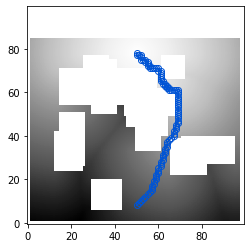

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  0.17649573087692266 vy:  0.24559298157691947 v:  0.3024345476588616
vx:  0.21255865693092346 vy:  0.47893399000167847 v:  0.5239837301054355
vx:  0.1482150107622146 vy:  0.6808637380599976 v:  0.6968092416294982
vx:  0.18168205022811912 vy:  0.8372535109519958 v:  0.8567390553584777
vx:  0.22178727388381975 vy:  0.8275338411331177 v:  0.8567390810960759
vx:  0.23243775963783253 vy:  0.8246056437492371 v:  0.8567390383357983
vx:  0.230768755078316 vy:  0.8250742554664611 v:  0.8567390182277977
vx:  0.2265283465385436 vy:  0.8262485861778258 v:  0.8567390605933306
vx:  0.19060921669006342 vy:  0.8120568990707397 v:  0.8341272569671759
vx:  0.11477595567703247 vy:  0.7795746326446533 v:  0.7879785072352051
vx:  0.05214789509773249 vy:  0.7483916282653809 v:  0.7502062597851554
vx:  0.01729466766118981 vy:  0.7184560298919678 v:  0.7186641582948458
vx:  -0.01600964739918731 vy:  0.6897176504135132 v:  0.6899034324467327
vx:  -0.03597562015056616 vy: 

vx:  0.012831151485443087 vy:  0.3053434491157532 v:  0.3056129257187054
vx:  0.01201409101486206 vy:  0.29312971234321594 v:  0.29337581127511164
vx:  0.011214017868042075 vy:  0.2814045250415802 v:  0.2816278766575179
vx:  0.010434150695800781 vy:  0.270148366689682 v:  0.2703497947582827
vx:  0.009677350521087702 vy:  0.2593424320220947 v:  0.25952292415168804
vx:  0.005924284458160414 vy:  0.2489687204360962 v:  0.24903919551333326
idx:  0
vx:  0.32493823766708374 vy:  0.23900997638702395 v:  0.4033740535913483
vx:  0.363788843154907 vy:  0.7756671905517579 v:  0.856739116010494
vx:  0.3637888431549072 vy:  0.7756670713424682 v:  0.8567390080818004
vx:  0.36378875374794006 vy:  0.7756671905517578 v:  0.8567390780464822
vx:  0.36212727427482594 vy:  0.7721245288848877 v:  0.8528261551332866
vx:  0.35314175486564614 vy:  0.7529655694961549 v:  0.8316647448799649
vx:  0.342596173286438 vy:  0.7304804921150208 v:  0.806829528036198
vx:  0.3302756547927856 vy:  0.7042105197906494 v:  0.

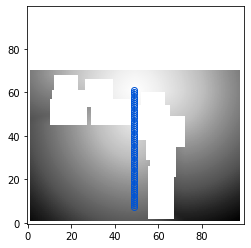

vx:  -0.0 vy:  0.0 v:  0.0
idx:  0
vx:  0.033867787569761235 vy:  0.4320300221443176 v:  0.4333554742574392
vx:  -0.005389466881752014 vy:  0.6967029571533203 v:  0.6967238024206226
vx:  -0.03300704434514046 vy:  0.8372114896774292 v:  0.8378618880366275
vx:  -0.04048886895179751 vy:  0.9206843376159668 v:  0.9215741956241762
vx:  -0.0008915998041630069 vy:  0.9418008327484131 v:  0.9418012547856448
vx:  0.002278280211612471 vy:  0.9417984485626221 v:  0.9418012042228894
vx:  0.002278280211612471 vy:  0.9417984485626221 v:  0.9418012042228894
vx:  0.002278280211612471 vy:  0.9417984485626221 v:  0.9418012042228894
vx:  0.002278280211612471 vy:  0.9417984485626221 v:  0.9418012042228894
vx:  0.0017146532190963626 vy:  0.9417996406555176 v:  0.9418012015146954
vx:  0.0017146532190963626 vy:  0.9417996406555176 v:  0.9418012015146954
vx:  0.0017146532190963626 vy:  0.9417996406555176 v:  0.9418012015146954
vx:  0.0017146532190963626 vy:  0.9417996406555176 v:  0.9418012015146954
vx:  -0.0

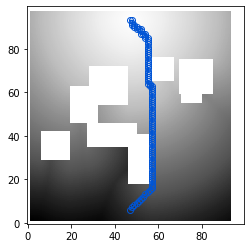

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  0.20380979776382446 vy:  0.5300763249397278 v:  0.5679078657019454
vx:  0.23918801546096802 vy:  0.5222835540771484 v:  0.5744484464245803
vx:  0.23383718729019168 vy:  0.5013922452926637 v:  0.5532395627568647
vx:  0.22818259894847873 vy:  0.4813366234302521 v:  0.5326839996828501
vx:  0.2222428172826767 vy:  0.4620830714702606 v:  0.5127500704759885
vx:  0.21603846549987793 vy:  0.4435997307300568 v:  0.4934099103983633
vx:  0.20959222316741943 vy:  0.42585584521293646 v:  0.47463891635040406
vx:  0.2029285877943039 vy:  0.4088215231895447 v:  0.4564154352858916
vx:  0.1960737109184265 vy:  0.39246869087219244 v:  0.4387215215011172
vx:  0.18905526399612427 vy:  0.37676987051963806 v:  0.4215417276806996
vx:  0.18190203607082367 vy:  0.36169913411140436 v:  0.4048636984759821
vx:  0.17464379966259003 vy:  0.3472311496734619 v:  0.3886771514562452
vx:  0.12572671473026273 vy:  0.33334192633628845 v:  0.35626401256715845
vx:  0.12152465432882309 v

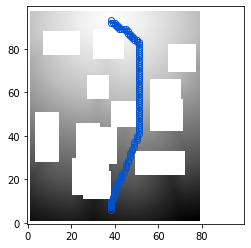

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  0.13403347134590154 vy:  0.30514636635780334 v:  0.33328557775937945
vx:  0.03385299444198617 vy:  0.5178705453872681 v:  0.5189758443438341
vx:  0.011245787143707275 vy:  0.6473369002342224 v:  0.6474345759482831
vx:  0.012299120426178034 vy:  0.7079690098762512 v:  0.7080758344333021
vx:  0.012494288384914287 vy:  0.7192036509513856 v:  0.7193121706074823
vx:  0.011981647461652811 vy:  0.6896947622299195 v:  0.6897988293142289
vx:  0.011446947231888882 vy:  0.658914625644684 v:  0.6590140487799966
vx:  0.010963953100144863 vy:  0.6311148405075073 v:  0.6312100681836424
vx:  0.01051284279674286 vy:  0.605145275592804 v:  0.6052365855068245
vx:  0.010084952227771254 vy:  0.580516815185547 v:  0.5806044083320475
vx:  0.00967653188854456 vy:  0.5570067763328552 v:  0.5570908221736465
vx:  0.009285565465688761 vy:  0.5345004796981813 v:  0.5345811299733685
vx:  0.00891078170388937 vy:  0.512927770614624 v:  0.5130051655668417
vx:  0.00855128187686202

vx:  -0.00013608048902823133 vy:  0.1042364165186882 v:  0.10423650534508987
idx:  0
vx:  -0.00013060955097897453 vy:  0.10006727278232574 v:  0.10006735801922222
idx:  0
vx:  -0.00012539158342404766 vy:  0.09606489539146423 v:  0.09606497722699027
idx:  0
vx:  -0.00012029852950944109 vy:  0.09222255647182465 v:  0.09222263493272727
idx:  0
vx:  -0.002253833692520857 vy:  0.0889241173863411 v:  0.08895267516636761
idx:  0
vx:  -0.007926093414425846 vy:  0.0866057872772217 v:  0.0869677258913994
idx:  0
vx:  -0.009544683620333679 vy:  0.08387792110443115 v:  0.08441923142396786
idx:  0
vx:  -0.014696680009365075 vy:  0.08233457803726198 v:  0.0836359680034353
idx:  0
vx:  -0.016032692044973373 vy:  0.07995758950710297 v:  0.08154914673983618
idx:  0
vx:  -0.021015303209424022 vy:  0.07927735149860382 v:  0.08201549505805113
idx:  0
vx:  -0.02232640795409679 vy:  0.07739555090665819 v:  0.080551472936737
idx:  0
vx:  -0.02763518318533898 vy:  0.07797578722238542 v:  0.08272802876074085
i

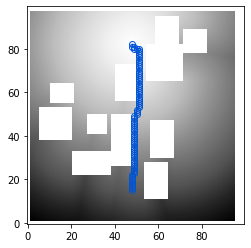

vx:  -0.0 vy:  0.0 v:  0.0
idx:  0
vx:  0.03290171176195142 vy:  0.48385980725288386 v:  0.48497714967992506
vx:  0.24236467480659485 vy:  0.8248264789581299 v:  0.8596972467005887
vx:  0.04054372012615215 vy:  0.8587405681610107 v:  0.8596971307659246
vx:  0.04054373502731326 vy:  0.8587406277656554 v:  0.8596971910069946
vx:  0.04054372012615215 vy:  0.8587405681610107 v:  0.8596971307659246
vx:  0.04054373502731326 vy:  0.8587405681610107 v:  0.8596971314686706
vx:  0.040543727576732635 vy:  0.8587405681610107 v:  0.8596971311172975
vx:  0.040543716400861685 vy:  0.8587405681610107 v:  0.8596971305902382
vx:  0.040543727576732635 vy:  0.8587405681610107 v:  0.8596971311172975
vx:  0.04186652600765223 vy:  0.8416314125061035 v:  0.8426720836226678
vx:  0.08515558391809466 vy:  0.8364425897598267 v:  0.8407661264802224
vx:  0.12536863982677457 vy:  0.8505067825317383 v:  0.8596970879237088
vx:  0.15284536778926838 vy:  0.846000909805298 v:  0.8596971826439986
vx:  0.17882201075553883 

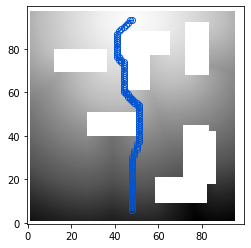

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -0.090074948966503 vy:  0.5347931385040283 v:  0.5423257300020966
vx:  -0.05645373463630665 vy:  0.8600722551345824 v:  0.8619230291659881
vx:  0.007295642048120443 vy:  0.9256410598754882 v:  0.9256698105265783
vx:  0.007295642048120443 vy:  0.9256410598754882 v:  0.9256698105265783
vx:  0.007295642048120443 vy:  0.9256410598754882 v:  0.9256698105265783
vx:  0.007295642048120443 vy:  0.9256410598754882 v:  0.9256698105265783
vx:  0.005461570806801319 vy:  0.9256536960601806 v:  0.92566980818516
vx:  0.005461570806801319 vy:  0.9256536960601806 v:  0.92566980818516
vx:  0.005461570806801319 vy:  0.9256536960601806 v:  0.92566980818516
vx:  0.005461570806801319 vy:  0.9256536960601806 v:  0.92566980818516
vx:  0.005461570806801319 vy:  0.9256536960601806 v:  0.92566980818516
vx:  0.005461570806801319 vy:  0.9256536960601806 v:  0.92566980818516
vx:  0.004049210809170978 vy:  0.925661027431488 v:  0.9256698838212762
vx:  0.004049210809170978 vy:  0

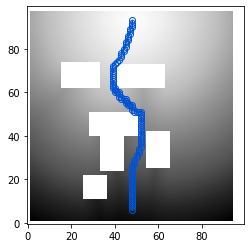

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  0.10890409350395208 vy:  0.3264450430870056 v:  0.34413146868311023
vx:  -0.010064937174320221 vy:  0.6577883362770081 v:  0.6578653344738551
vx:  -0.03018488734960567 vy:  0.8714826107025145 v:  0.872005199629669
vx:  -0.01169572025537513 vy:  0.9808046221733092 v:  0.980874353191488
vx:  -0.0033185714855790693 vy:  0.9999945163726807 v:  1.000000022846068
vx:  -0.0033185714855790693 vy:  0.9999945163726807 v:  1.000000022846068
vx:  -0.0033185717184096575 vy:  0.9999945163726807 v:  1.0000000228468406
vx:  -0.0024527201894669615 vy:  0.999997019767761 v:  1.0000000276903653
vx:  -0.0024527201894669615 vy:  0.999997019767761 v:  1.0000000276903653
vx:  -0.0024527201894669615 vy:  0.999997019767761 v:  1.0000000276903653
vx:  -0.0024527201894669615 vy:  0.999997019767761 v:  1.0000000276903653
vx:  -0.007901092991232539 vy:  0.9907110333442688 v:  0.9907425391394704
vx:  -0.018385142087936512 vy:  0.9709223508834839 v:  0.9710964035020955


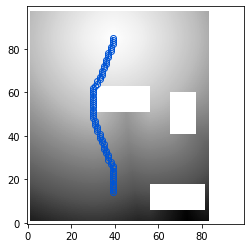

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  0.05237494409084332 vy:  0.5802468657493592 v:  0.5826058358620122
vx:  0.032789550721645584 vy:  0.8657416105270385 v:  0.8663623323035679
vx:  -0.004308644216507715 vy:  0.9039993286132812 v:  0.9040095964912362
vx:  -0.004308644216507715 vy:  0.9039993286132812 v:  0.9040095964912362
vx:  -0.004308644216507715 vy:  0.9039993286132812 v:  0.9040095964912362
vx:  -0.004308644216507715 vy:  0.9039993286132812 v:  0.9040095964912362
vx:  -0.004308644216507715 vy:  0.9039993286132812 v:  0.9040095964912362
vx:  -0.0031345419120042822 vy:  0.9040040969848633 v:  0.9040095313205587
vx:  -0.008012980222702262 vy:  0.9039739966392517 v:  0.9040095101557236
vx:  -0.06646375358104686 vy:  0.9009722471237183 v:  0.903420400825244
vx:  -0.07639370113611246 vy:  0.8825278282165527 v:  0.8858280674882112
vx:  -0.05804048851132376 vy:  0.902144432067871 v:  0.9040095544946937
vx:  -0.052107643336057635 vy:  0.9025065302848816 v:  0.9040095373948738
vx:  -0.06

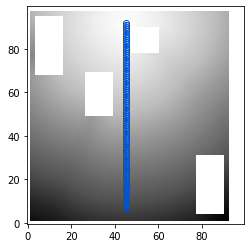

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  0.22745096683502197 vy:  0.3146941661834717 v:  0.3882864413601082
vx:  0.19459936022758478 vy:  0.6471174359321594 v:  0.6757439506857592
vx:  0.13870766758918768 vy:  0.8335871696472166 v:  0.8450487479716717
vx:  0.08796242624521244 vy:  0.9246649146080017 v:  0.9288393794074234
vx:  0.05488389730453497 vy:  0.9623602032661437 v:  0.963923961219861
vx:  0.03967967256903643 vy:  0.9755783081054685 v:  0.9763849198247146
vx:  0.03625334799289698 vy:  0.978595197200775 v:  0.9792664934659604
vx:  0.040114775300025884 vy:  0.9813067913055419 v:  0.9821263736707969
vx:  0.046808924525976126 vy:  0.9802602529525757 v:  0.9813772154140966
vx:  0.05469899624586111 vy:  0.9767042398452758 v:  0.9782347122863934
vx:  0.06261098384857161 vy:  0.970404326915741 v:  0.9724220755388466
vx:  0.0693487077951433 vy:  0.9599620699882507 v:  0.9624637235184417
vx:  0.09377337247133266 vy:  0.9640803933143614 v:  0.9686301926730454
vx:  0.1158151850104332 vy:  0.9

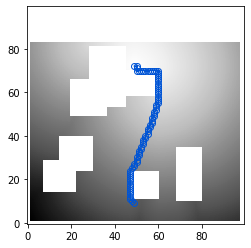

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -0.19395485520362846 vy:  0.18445408344268802 v:  0.2676598489795259
vx:  -0.13740088045597068 vy:  0.6758999228477477 v:  0.6897243707856546
vx:  -0.14998354017734516 vy:  0.9098221063613892 v:  0.9221015820114421
vx:  -0.14998352527618428 vy:  0.909822106361389 v:  0.9221015795877082
vx:  -0.1499836295843125 vy:  0.9098222255706786 v:  0.9221017141756472
vx:  -0.14998340606689406 vy:  0.9098221063613893 v:  0.9221015601978461
vx:  -0.149983465671539 vy:  0.9098221063613892 v:  0.9221015698927753
vx:  -0.018310332670807755 vy:  0.9219197034835815 v:  0.9221015171627095
vx:  0.0019967723637823176 vy:  0.9203981161117554 v:  0.920400282074023
vx:  0.0002559395506979978 vy:  0.8864526748657225 v:  0.8864527118135789
vx:  -0.025319630280136923 vy:  0.8448100686073303 v:  0.8451894081789271
vx:  -0.0698374733328822 vy:  0.8051726222038269 v:  0.8081956596196911
vx:  -0.1665836572647096 vy:  0.8490548133850098 v:  0.8652422730079362
vx:  -0.16612216830

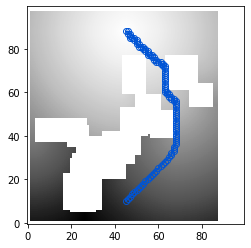

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -0.27369773387908924 vy:  0.36780068278312694 v:  0.4584624213458319
vx:  -0.07297342270612722 vy:  0.40479403734207153 v:  0.41131901620170874
vx:  0.18737448751926433 vy:  0.4181037545204162 v:  0.4581702174052515
vx:  0.31453683972358726 vy:  0.46506652235984797 v:  0.5614448269983299
vx:  0.33683344721794145 vy:  0.5020269155502318 v:  0.6045558659889103
vx:  0.3450472652912142 vy:  0.5172669887542725 v:  0.6217899588605932
vx:  0.35934987664222723 vy:  0.5424147844314574 v:  0.6506505453871596
vx:  0.38138142228126526 vy:  0.5807751417160034 v:  0.69480324876653
vx:  0.5899742841720582 vy:  0.5050090551376342 v:  0.7765975803177206
vx:  0.45731282234191895 vy:  0.5878864526748657 v:  0.7448123916242053
vx:  0.45453891158103926 vy:  0.5864216685295107 v:  0.74195417342462
vx:  0.4451774060726166 vy:  0.5743125081062317 v:  0.726648319233461
vx:  0.4311443865299227 vy:  0.5555313825607299 v:  0.7032073656085376
vx:  0.4142133593559264 vy:  0.53

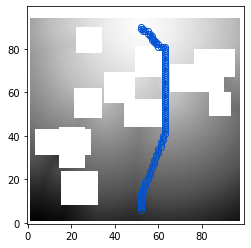

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -0.13386155664920807 vy:  0.3547919988632202 v:  0.3792047979732171
vx:  -0.07266018539667132 vy:  0.6104827523231506 v:  0.6147915853571256
vx:  -0.005188975483179037 vy:  0.8123030066490172 v:  0.8123195800161401
vx:  0.014640636742115076 vy:  0.950490117073059 v:  0.9506028670784514
vx:  0.012073217891156618 vy:  0.9999271035194397 v:  0.9999999874715118
vx:  0.012073217891156618 vy:  0.9999271035194397 v:  0.9999999874715118
vx:  0.012073217891156618 vy:  0.9999271035194397 v:  0.9999999874715118
vx:  0.012073217891156618 vy:  0.9999271035194397 v:  0.9999999874715118
vx:  0.008588592521846461 vy:  0.9999631047248839 v:  0.9999999873662676
vx:  0.2214648574590684 vy:  0.8641092777252196 v:  0.8920378506207941
vx:  0.3051260113716126 vy:  0.9420546889305115 v:  0.9902367998370452
vx:  0.302899956703186 vy:  0.9530223608016968 v:  1.0000000019794157
vx:  0.302899956703186 vy:  0.9530223608016968 v:  1.0000000019794157
vx:  0.2786186337471009 vy:

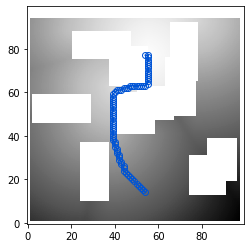

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -0.1696421205997467 vy:  0.28962367773056025 v:  0.33564910812298376
vx:  -0.4240519404411316 vy:  0.4472089707851411 v:  0.6162920669151877
vx:  -0.6094841361045837 vy:  0.5866571068763733 v:  0.8459535880955333
vx:  -0.5661172866821289 vy:  0.672120988368988 v:  0.8787692559975235
vx:  -0.5326017141342161 vy:  0.6989784240722656 v:  0.8787692661997535
vx:  -0.5148727893829347 vy:  0.7121385335922241 v:  0.8787691848681581
vx:  -0.5056608319282532 vy:  0.718708872795105 v:  0.8787692079156981
vx:  -0.5009138584136963 vy:  0.7220252752304077 v:  0.8787691344274915
vx:  -0.49827539920806885 vy:  0.7238487005233766 v:  0.8787692044589075
vx:  -0.496746152639389 vy:  0.7248989939689637 v:  0.8787691913234389
vx:  -0.4957976341247559 vy:  0.7255480885505676 v:  0.8787692090663439
vx:  -0.4951504766941072 vy:  0.7259899377822875 v:  0.8787692440746497
vx:  -0.4946568608283997 vy:  0.726326286792755 v:  0.8787691874723182
vx:  -0.49424725770950306 vy:  

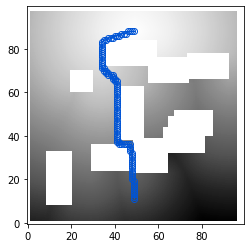

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -0.13702252507209767 vy:  0.5448561906814575 v:  0.5618215383029048
vx:  0.0028257966041565635 vy:  0.5497618317604065 v:  0.5497690940631399
vx:  -0.017443686723708995 vy:  0.7252358198165895 v:  0.7254455710468949
vx:  -0.00040961732156555297 vy:  0.9452884197235107 v:  0.9452885084722665
vx:  -0.000409639207646445 vy:  0.9452884197235109 v:  0.9452885084817507
vx:  -0.00040665268897996376 vy:  0.9384425878524781 v:  0.9384426759593074
vx:  -0.0003903955221177535 vy:  0.9009047746658326 v:  0.9009048592522733
vx:  -0.0003747791051860183 vy:  0.8648686408996582 v:  0.8648687221023775
vx:  -0.00035978853702545166 vy:  0.8302739262580872 v:  0.8302740042129532
vx:  -0.00034539401531241687 vy:  0.7970629930496215 v:  0.7970630678849991
vx:  -0.00033159554004666414 vy:  0.7651802897453308 v:  0.7651803615948011
vx:  -0.00031833350658380666 vy:  0.7345733046531678 v:  0.7345733736294129
vx:  -0.0003055781126020951 vy:  0.7051902413368225 v:  0.7051903

vx:  0.18254411220550534 vy:  0.5124698877334595 v:  0.5440107891709876


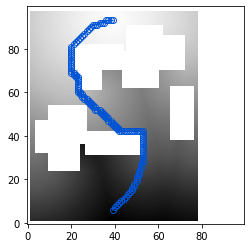

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  0.23342479765415186 vy:  0.3919884860515595 v:  0.4562259411266258
vx:  0.49807447195053084 vy:  0.8543233871459963 v:  0.9889118410826154
vx:  0.4873164296150211 vy:  0.8732254505157471 v:  0.9999999950005806
vx:  0.4873164296150211 vy:  0.8732254505157471 v:  0.9999999950005806
vx:  0.4873164296150211 vy:  0.8732254505157471 v:  0.9999999950005806
vx:  0.43225717544555686 vy:  0.872047781944275 v:  0.973300364593634
vx:  0.43665704131126426 vy:  0.8590452671051025 v:  0.9636535387069277
vx:  0.4577527344226835 vy:  0.8839411735534669 v:  0.9954343595509069
vx:  0.45750921964645386 vy:  0.8834710717201234 v:  0.9949049304470305
vx:  0.45722109079360984 vy:  0.882914662361145 v:  0.9942783447701117
vx:  0.4568768143653868 vy:  0.8822497129440309 v:  0.9935295564272303
vx:  0.44960513710975625 vy:  0.8682076930999758 v:  0.9777164096369992
vx:  0.44850358366966225 vy:  0.8660807013511659 v:  0.9753210988271797
vx:  0.4472205936908723 vy:  0.863603

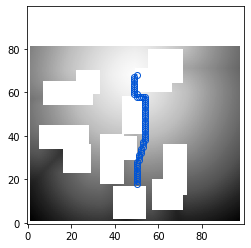

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  0.06525309383869168 vy:  0.5248464345932006 v:  0.5288872716947496
vx:  0.03361771255731602 vy:  0.6941749453544617 v:  0.6949884929662189
vx:  -0.0028372630476952293 vy:  0.7570915222167969 v:  0.7570968386370058
vx:  -0.006350681185722268 vy:  0.7628955841064452 v:  0.7629220165918905
vx:  -0.0004429607652130241 vy:  0.7486329078674316 v:  0.7486330389157868
vx:  0.06745167821645713 vy:  0.7523183822631836 v:  0.7553361352307396
vx:  0.06168330088257799 vy:  0.7435413002967833 v:  0.7460954998221085
vx:  0.031569480895996 vy:  0.7201828956604003 v:  0.7208744934632114
vx:  0.008913505822420231 vy:  0.7028426527976989 v:  0.7028991714163226
vx:  -0.011960757896304151 vy:  0.6872583031654358 v:  0.6873623753154431
vx:  -0.014258325099945027 vy:  0.6477984189987182 v:  0.647955315968543
vx:  -0.013258364051580415 vy:  0.602367103099823 v:  0.6025129966350908
vx:  -0.011914487928152084 vy:  0.5413107872009276 v:  0.5414418928774148
vx:  0.0090644732

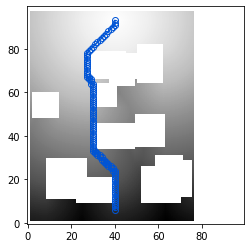

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  0.05237755179405216 vy:  0.23436719179153442 v:  0.2401486800300774
idx:  0
vx:  0.032031618058681544 vy:  0.49893048405647283 v:  0.4999576506828189
vx:  0.06324014812707904 vy:  0.6952342391014099 v:  0.6981045505897031
vx:  0.060764353722333866 vy:  0.8556160926818847 v:  0.8577710677911142
vx:  -0.010580196045339219 vy:  0.8993516564369202 v:  0.8994138883095979
vx:  -0.010580196045339219 vy:  0.8993516564369202 v:  0.8994138883095979
vx:  -0.010580196045339219 vy:  0.8993516564369202 v:  0.8994138883095979
vx:  -0.02428219467401513 vy:  0.8910847306251524 v:  0.8914155159808961
vx:  -0.03089379891753194 vy:  0.8682033419609071 v:  0.8687528243428304
vx:  -0.029626227915287212 vy:  0.8376171588897705 v:  0.8381409298244894
vx:  -0.008584927767515127 vy:  0.8048114776611327 v:  0.8048572640908879
vx:  0.05325444415211694 vy:  0.7905054092407228 v:  0.7922971903653284
vx:  0.13065478205680858 vy:  0.8307791352272033 v:  0.840990275569921
vx:  0

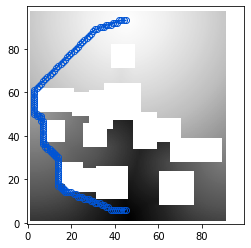

vx:  -0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -0.4419146478176117 vy:  0.18366989493370062 v:  0.47856367001760636
vx:  -0.8886041045188904 vy:  0.3438518047332765 v:  0.9528123205469955
vx:  -0.8855528235435487 vy:  0.33009770512580866 v:  0.9450758161202079
vx:  -0.881708562374115 vy:  0.31689390540122986 v:  0.9369267507357617
vx:  -0.9076676964759826 vy:  0.30964553356170643 v:  0.9590312839948081
vx:  -0.9297212958335875 vy:  0.32041114568710344 v:  0.983384456968386
vx:  -0.9446344971656799 vy:  0.32555076479911815 v:  0.9991584627559073
vx:  -0.9445263147354127 vy:  0.3255134820938109 v:  0.9990440361928485
vx:  -0.9443945884704589 vy:  0.32546812295913713 v:  0.9989047190772659
vx:  -0.9442318081855774 vy:  0.32541185617446905 v:  0.9987324885715485
vx:  -0.9440274238586427 vy:  0.32534155249595653 v:  0.9985163507813303
vx:  -0.943766176700592 vy:  0.325251489877701 v:  0.9982400152026152
vx:  -0.9645251631736755 vy:  0.2639908194541929 v:  0.9999999715756505
vx:  -0.964525163173675

vx:  0.00018400467524772035 vy:  0.11770061403512955 v:  0.11770075786487973
idx:  0
vx:  0.00018411382916382404 vy:  0.11770062893629074 v:  0.11770077293671648
idx:  0
vx:  0.00018404441652820555 vy:  0.11770060658454896 v:  0.11770075047644354
idx:  0
vx:  -0.00010736659169199338 vy:  -0.0687013640999794 v:  0.06870144799626096
idx:  0


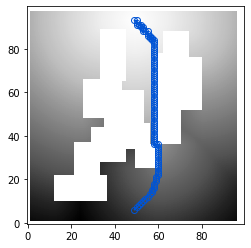

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -0.03966720402240755 vy:  0.28428754210472107 v:  0.2870416235860208
vx:  0.07434778660535808 vy:  0.4110482037067414 v:  0.41771787027089785
vx:  0.15962712466716766 vy:  0.5364235043525696 v:  0.5596704342301805
vx:  0.44058126211166365 vy:  0.5777431130409241 v:  0.7265665511087918
vx:  0.48863857984542847 vy:  0.7946208715438843 v:  0.9328397457261989
vx:  0.4717687964439392 vy:  0.876264214515686 v:  0.9951908213699296
vx:  0.47392049431800853 vy:  0.8802608251571655 v:  0.9997298411275916
vx:  0.4739055037498473 vy:  0.8802329897880553 v:  0.999698225863993
vx:  0.4698607921600341 vy:  0.8727203607559204 v:  0.9911659760540606
vx:  0.4694403409957886 vy:  0.8719393610954286 v:  0.9902789925984224
vx:  0.46895408630371105 vy:  0.8710361719131469 v:  0.9892532273599403
vx:  0.46838778257370006 vy:  0.8699843883514404 v:  0.9880586778322114
vx:  0.46772313117980946 vy:  0.8687498569488527 v:  0.9866565974995035
vx:  0.46693629026412964 vy:  0.8

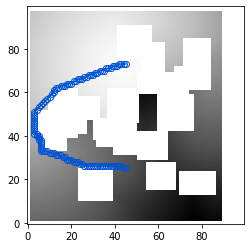

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  -0.25712439417839056 vy:  0.25228300690650934 v:  0.3602216951481326
vx:  -0.8533278703689574 vy:  0.20391733944416063 v:  0.8773543957115649
vx:  -0.8533278703689574 vy:  0.20391733944416063 v:  0.8773543957115649
vx:  -0.8533278703689574 vy:  0.20391733944416063 v:  0.8773543957115649
vx:  -0.8533278703689574 vy:  0.20391733944416063 v:  0.8773543957115649
vx:  -0.8533278703689574 vy:  0.20391733944416063 v:  0.8773543957115649
vx:  -0.8533278703689574 vy:  0.20391733944416063 v:  0.8773543957115649
vx:  -0.8667030930519104 vy:  0.13629539310932148 v:  0.8773543672248819
vx:  -0.8667030930519104 vy:  0.13629539310932148 v:  0.8773543672248819
vx:  -0.8667030930519104 vy:  0.13629540801048295 v:  0.8773543695397501
vx:  -0.8667030930519104 vy:  0.13629539310932148 v:  0.8773543672248819
vx:  -0.8667030930519104 vy:  0.13629539310932148 v:  0.8773543672248819
vx:  -0.8724820613861084 vy:  0.09233511239290242 v:  0.8773543870188164
vx:  -0.8724820

vx:  0.26393058896064764 vy:  -0.0547290295362472 v:  0.26954521413502
vx:  -0.2402230352163315 vy:  0.0036226511001587296 v:  0.24025034911429438
idx:  0
vx:  0.3580961525440216 vy:  -0.11100670695304855 v:  0.3749071131032208
vx:  -0.2357134073972702 vy:  -0.0038765668869017687 v:  0.23574528245048743
idx:  0
vx:  0.04117334634065629 vy:  -0.018790904432535158 v:  0.045258618386781364
idx:  0
vx:  -0.22793181240558624 vy:  0.005965232849121118 v:  0.22800985748304742
idx:  0
vx:  -0.07868708670139313 vy:  0.050022773444652543 v:  0.09324127560607262
idx:  0
vx:  0.1683263778686523 vy:  -0.10700795054435738 v:  0.19946044962870196
idx:  0
vx:  0.45843920111656195 vy:  0.0025219023227690124 v:  0.4584461376342014
vx:  -0.23211099207401278 vy:  -0.0018075704574585065 v:  0.23211803021855304
idx:  0
vx:  0.08924011141061783 vy:  -0.035646095871925375 v:  0.09609600218266096
idx:  0
vx:  0.45713749527931213 vy:  0.003919184207916093 v:  0.45715429517297407
vx:  -0.24468167126178744 vy:  -

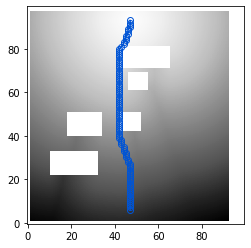

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -0.009776255115866689 vy:  0.3478537797927857 v:  0.3479911310367239
vx:  0.022602271288633402 vy:  0.7832317352294923 v:  0.7835577922131887
vx:  -0.0006797430105506819 vy:  0.999999761581421 v:  0.9999999926067296
vx:  -0.0006797430105506819 vy:  0.999999761581421 v:  0.9999999926067296
vx:  -0.0006797430105506819 vy:  0.999999761581421 v:  0.9999999926067296
vx:  -0.0006797430105506819 vy:  0.999999761581421 v:  0.9999999926067296
vx:  -0.0005086861783638041 vy:  0.9999998807907107 v:  1.0000000101715318
vx:  -0.0005086861783638041 vy:  0.9999998807907107 v:  1.0000000101715318
vx:  -0.0005086861783638041 vy:  0.9999998807907107 v:  1.0000000101715318
vx:  -0.0005086861783638041 vy:  0.9999998807907107 v:  1.0000000101715318
vx:  -0.0005086861783638041 vy:  0.9999998807907107 v:  1.0000000101715318
vx:  -0.0005086861783638041 vy:  0.9999998807907107 v:  1.0000000101715318
vx:  -0.00037389146746130697 vy:  0.9999999403953554 v:  1.00000001029277

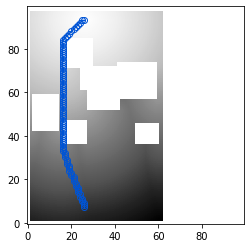

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  0.007834089919924736 vy:  0.5505329966545105 v:  0.550588733421116
vx:  -0.2588129043579102 vy:  0.9183484911918639 v:  0.9541216226124161
vx:  -0.24825038015842427 vy:  0.968695878982544 v:  0.9999999786032826
vx:  -0.24825038015842427 vy:  0.968695878982544 v:  0.9999999786032826
vx:  -0.24825038015842427 vy:  0.968695878982544 v:  0.9999999786032826
vx:  -0.24825039505958568 vy:  0.968695878982544 v:  0.9999999823025018
vx:  -0.18768858909606928 vy:  0.9822285771369934 v:  0.9999999921107179
vx:  -0.18768858909606928 vy:  0.9822285771369934 v:  0.9999999921107179
vx:  -0.18768858909606922 vy:  0.9754577279090881 v:  0.9933502833413971
vx:  -0.44009789824485773 vy:  0.8979498147964475 v:  1.0000000149662576
vx:  -0.44009789824485773 vy:  0.8979498147964475 v:  1.0000000149662576
vx:  -0.44009789824485773 vy:  0.8979498147964475 v:  1.0000000149662576
vx:  -0.3397931158542633 vy:  0.9405001997947693 v:  0.9999999936979749
vx:  -0.3397931158542633

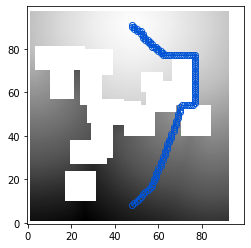

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  0.23390324413776387 vy:  0.5552232265472412 v:  0.6024811689303654
vx:  0.5084025263786316 vy:  0.8147878646850585 v:  0.9603917915445822
vx:  0.5088325142860414 vy:  0.8600058555603025 v:  0.9992600258154343
vx:  0.4040888249874111 vy:  0.9139106869697571 v:  0.9992599873092287
vx:  0.4040888249874111 vy:  0.9139106869697571 v:  0.9992599873092287
vx:  0.4040888249874111 vy:  0.9139106869697571 v:  0.9992599873092287
vx:  0.4040888249874111 vy:  0.9139106869697571 v:  0.9992599873092287
vx:  0.4040888249874111 vy:  0.9139106869697571 v:  0.9992599873092287
vx:  0.4040888249874111 vy:  0.9139106869697571 v:  0.9992599873092287
vx:  0.3111123442649839 vy:  0.9495944976806641 v:  0.9992600266094139
vx:  0.3111123442649839 vy:  0.9495944976806641 v:  0.9992600266094139
vx:  0.2979257702827452 vy:  0.9476576447486877 v:  0.9933855124015032
vx:  0.27464190125465404 vy:  0.8730005621910095 v:  0.9151820340842525
vx:  0.3004223704338074 vy:  0.771176755

vx:  8.271806125530277e-25 vy:  -9.313225746154784e-09 v:  9.313225746154784e-09
idx:  0
vx:  0.43913015723228455 vy:  0.022702306509018 v:  0.4397166015875229
vx:  0.17919255793094635 vy:  0.038498695939779254 v:  0.18328153864178232
idx:  0
vx:  -0.07223676145076752 vy:  -0.015519738197326667 v:  0.07388512691068921
idx:  0
vx:  -0.215346947312355 vy:  0.020875060930848136 v:  0.21635636317339232
idx:  0
vx:  -0.2067330628633499 vy:  0.026493361219763728 v:  0.20842374497542898
idx:  0
vx:  0.0 vy:  -5.587935447692871e-09 v:  5.587935447692871e-09
idx:  0
vx:  0.6975193023681641 vy:  0.018980324268341148 v:  0.6977774931061489
vx:  0.07838493585586549 vy:  0.016600042581558228 v:  0.08012340221706574
idx:  0
vx:  -0.22949986159801483 vy:  0.00500905886292459 v:  0.22955451889300765
idx:  0
vx:  -0.22031988203525543 vy:  0.02261921204626556 v:  0.22147794286028302
idx:  0
vx:  -0.21150706708431244 vy:  0.021714432165026623 v:  0.21261880441498437
idx:  0
vx:  -0.20304684340953827 vy: 

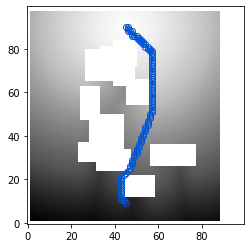

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  -0.1200036704540253 vy:  0.2136251479387283 v:  0.24502364121505063
idx:  0
vx:  -0.23405098915100098 vy:  0.7203965187072754 v:  0.7574635368703392
vx:  -0.1250447034835815 vy:  0.6915804743766785 v:  0.7027942304888171
vx:  -0.12004283070564273 vy:  0.6639174222946167 v:  0.6746826104400142
vx:  -0.115241140127182 vy:  0.6373606324195863 v:  0.6476952185527602
vx:  -0.11063149571418765 vy:  0.6118662357330322 v:  0.6217874381764792
vx:  -0.1062062382698059 vy:  0.5873915553092957 v:  0.5969159105737559
vx:  -0.10195803642272946 vy:  0.5638958811759949 v:  0.5730392709042116
vx:  -0.09787961840629573 vy:  0.5413401126861572 v:  0.5501177485797232
vx:  -0.09396451711654663 vy:  0.5196864604949951 v:  0.5281130065608703
vx:  -0.09020602703094482 vy:  0.49889895319938654 v:  0.5069884543223359
vx:  -0.08659753203392034 vy:  0.47894302010536194 v:  0.4867088956059987
vx:  2.5987625122098068e-05 vy:  0.4597853124141693 v:  0.4597853131485954
vx:  2.4

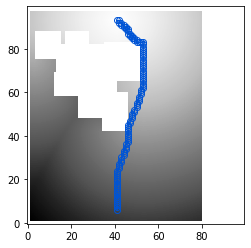

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -0.08005093038082113 vy:  0.5467357039451599 v:  0.5525650019891276
vx:  0.0035653144586829458 vy:  0.856054425239563 v:  0.8560618496577381
vx:  0.0035653144586829458 vy:  0.856054425239563 v:  0.8560618496577381
vx:  0.0035653144586829458 vy:  0.856054425239563 v:  0.8560618496577381
vx:  0.0035653144586829458 vy:  0.856054425239563 v:  0.8560618496577381
vx:  0.0035653144586829458 vy:  0.856054425239563 v:  0.8560618496577381
vx:  0.0035653144586829458 vy:  0.856054425239563 v:  0.8560618496577381


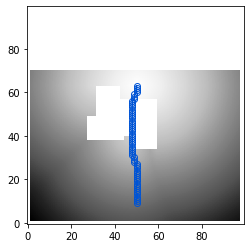

vx:  -0.0 vy:  0.0 v:  0.0
idx:  0
vx:  0.14228850603103638 vy:  0.5157132744789124 v:  0.534982430012712
vx:  0.14670479297637928 vy:  0.7866273522377013 v:  0.8001905320426748
vx:  0.09824005514383327 vy:  0.9227458238601685 v:  0.9279606478111259
vx:  0.050778135657310486 vy:  0.9265701770782471 v:  0.9279605121510539
vx:  0.04386739060282707 vy:  0.9269232153892517 v:  0.9279606646759604
vx:  0.056897092610597555 vy:  0.9221349358558655 v:  0.9238885858551561
vx:  0.07584204524755489 vy:  0.8852496147155762 v:  0.8884924851575325
vx:  0.08656592667102808 vy:  0.8498395681381224 v:  0.8542370579842602
vx:  0.08927918970584875 vy:  0.8158460855484008 v:  0.8207165217169576
vx:  0.08010970056056976 vy:  0.7832121849060059 v:  0.7872984762522685
vx:  0.06966570764780045 vy:  0.7518836855888366 v:  0.7551042229233798
vx:  0.04507570713758474 vy:  0.7218083143234253 v:  0.7232143955981366
vx:  -0.0012478418648242395 vy:  0.6929360032081603 v:  0.6929371267665048
vx:  -0.06032682955265045

vx:  -0.031319826841354356 vy:  0.15767589211463928 v:  0.16075639491951724
idx:  0


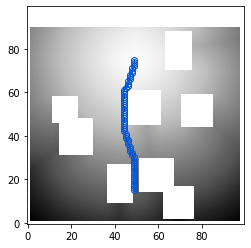

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -0.016524523496627766 vy:  0.37532031536102295 v:  0.3756839083584607
vx:  0.039662301540374506 vy:  0.6987380981445311 v:  0.699862863682676
vx:  0.003349274396896529 vy:  0.8237652778625488 v:  0.8237720865937058
vx:  -0.029305730015039277 vy:  0.8888470530509949 v:  0.889330034086982
vx:  -0.029997631907463018 vy:  0.9186991453170776 v:  0.9191887605526868
vx:  -0.0058433618396520615 vy:  0.9096466898918151 v:  0.9096654579067653
vx:  0.02575373277068166 vy:  0.8834825754165648 v:  0.8838578595092708
vx:  0.06197087094187731 vy:  0.8475587368011473 v:  0.8498212760182292
vx:  0.09977432340383549 vy:  0.8074721693992615 v:  0.8136130652620094
vx:  0.12235844880342489 vy:  0.7833260297775267 v:  0.7928248601807356
vx:  0.1341669261455534 vy:  0.7706989645957947 v:  0.7822900089483288
vx:  0.1443441212177278 vy:  0.7396870255470275 v:  0.7536392512951584
vx:  0.14761193096637737 vy:  0.7172064185142516 v:  0.7322392566106125
vx:  0.145409718155860

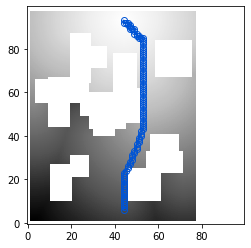

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -0.30575889348983765 vy:  0.5331109166145325 v:  0.614569565111808
vx:  0.0057535469532012384 vy:  0.8477223515510559 v:  0.8477418761756403
vx:  0.014041007496416624 vy:  0.8714240193367004 v:  0.8715371313767672
vx:  0.014041007496416624 vy:  0.8714240193367004 v:  0.8715371313767672
vx:  0.014041007496416624 vy:  0.8714240193367004 v:  0.8715371313767672
vx:  0.014041007496416624 vy:  0.8714240193367004 v:  0.8715371313767672
vx:  0.014041007496416624 vy:  0.8714240193367004 v:  0.8715371313767672
vx:  0.023682877421379256 vy:  0.8697590231895447 v:  0.8700813968259447
vx:  0.010125378146767616 vy:  0.8449209928512573 v:  0.8449816610100893
vx:  -0.06909776479005814 vy:  0.8539925217628479 v:  0.8567833613731364
vx:  -0.08516515791416163 vy:  0.8673660159111024 v:  0.8715370959861909
vx:  -0.09089152514934551 vy:  0.8667846918106079 v:  0.8715371313381803
vx:  -0.09613475203514099 vy:  0.8662188053131104 v:  0.8715370957262406
vx:  -0.101207286

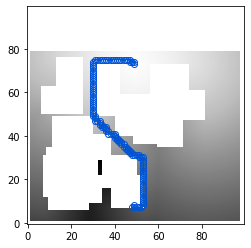

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  -5.960464477788429e-08 vy:  0.009045705199241636 v:  0.009045705199438012
idx:  0
vx:  0.4174800217151642 vy:  0.008683882653713067 v:  0.41757032742909
vx:  0.13484594225883478 vy:  0.023947663605213224 v:  0.1369559006973466
idx:  0
vx:  -0.1274510622024536 vy:  -0.022634476423263477 v:  0.12944532737603537
idx:  0
vx:  -0.4177969694137573 vy:  0.00828400999307638 v:  0.41787908834121557
vx:  -0.027397453784942627 vy:  0.000733315013349061 v:  0.027407265912652985
idx:  0
vx:  0.4180830419063568 vy:  0.007923327386379263 v:  0.4181581148878307
vx:  0.13314029574394226 vy:  0.021535798907279916 v:  0.13487078625617635
idx:  0
vx:  -0.26521429419517517 vy:  -0.04289897903800022 v:  0.2686613932963717
vx:  -0.01673153042793274 vy:  0.008460916578769686 v:  0.018749165843144563
idx:  0
vx:  -0.41792511940002436 vy:  0.008122451603412566 v:  0.4180040426186981
vx:  -0.011313319206237791 vy:  0.000304113142192366 v:  0.011317405898238474
idx:  0
vx: 

vx:  -0.009899705648422241 vy:  0.008493050932884216 v:  0.013043622429140176
idx:  0
vx:  -0.3005033135414123 vy:  0.00815325975418087 v:  0.3006139003672111
vx:  -0.012807637453079222 vy:  0.00034482358023524317 v:  0.012812278502709964
idx:  0
vx:  0.4181703627109527 vy:  0.007813371717930007 v:  0.4182433514443622
vx:  0.11836071312427521 vy:  0.017053809016942936 v:  0.1195829871397823
idx:  0
vx:  -0.2822737991809845 vy:  -0.04067088291048993 v:  0.2851887417497148
vx:  -0.008112579584121704 vy:  0.008445560932159422 v:  0.011710740666905993
idx:  0
vx:  -0.41793680191040034 vy:  0.008107669651508411 v:  0.4180154359569407
vx:  0.003631412982940674 vy:  -9.975023567676474e-05 v:  0.00363278272983503
idx:  0
vx:  0.41819101572036743 vy:  0.007787428796291317 v:  0.4182635170278301
vx:  0.12137479335069655 vy:  0.015619265846908143 v:  0.12237565904427515
idx:  0
vx:  -0.2971652448177338 vy:  -0.03824121877551068 v:  0.2996157097700655
vx:  -0.020123004913330078 vy:  0.000575094483

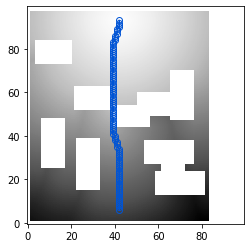

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  0.09101954102516173 vy:  0.8949774503707886 v:  0.8995939047818345
vx:  -0.004438349977135686 vy:  0.9316107034683228 v:  0.9316212759309777
vx:  -0.004438349977135686 vy:  0.9316107034683228 v:  0.9316212759309777
vx:  -0.004438349977135686 vy:  0.9316107034683228 v:  0.9316212759309777
vx:  -0.004438349977135686 vy:  0.9316107034683228 v:  0.9316212759309777
vx:  -0.004438349977135686 vy:  0.9316107034683228 v:  0.9316212759309777
vx:  -0.003297224873677007 vy:  0.93161541223526 v:  0.9316212470774489
vx:  -0.003297224873677007 vy:  0.93161541223526 v:  0.9316212470774489
vx:  -0.003297224873677007 vy:  0.93161541223526 v:  0.9316212470774489
vx:  -0.003297224873677007 vy:  0.93161541223526 v:  0.9316212470774489
vx:  -0.003297224873677007 vy:  0.93161541223526 v:  0.9316212470774489
vx:  -0.0024641319178045906 vy:  0.9316180944442748 v:  0.9316213532557581
vx:  0.021752208471298343 vy:  0.9254800081253052 v:  0.9257356015693649
vx:  0.017569804

vx:  -0.05041337758302694 vy:  0.9302562475204467 v:  0.9316212721327006
vx:  -0.0504133813083172 vy:  0.9302562475204467 v:  0.9316212723342895
vx:  -0.03268529847264294 vy:  0.931047797203064 v:  0.9316213444382452
vx:  0.3013291358947753 vy:  0.8815434575080872 v:  0.9316212296928428
vx:  0.3013291358947753 vy:  0.8815434575080872 v:  0.9316212296928428
vx:  0.3013291358947753 vy:  0.8815434575080872 v:  0.9316212296928428
vx:  0.301329165697098 vy:  0.881543457508087 v:  0.9316212393322845
vx:  0.3013291358947753 vy:  0.8815434575080872 v:  0.9316212296928428
vx:  0.1988551914691925 vy:  0.9101510047912598 v:  0.931621295751009
vx:  0.19885520637035353 vy:  0.9101510047912598 v:  0.9316212989316719
vx:  0.19885520637035353 vy:  0.9101510047912598 v:  0.9316212989316719
vx:  0.19885520637035353 vy:  0.9101510047912598 v:  0.9316212989316719
vx:  0.19885520637035353 vy:  0.9101510047912598 v:  0.9316212989316719
vx:  0.14071409404277796 vy:  0.8942524790763855 v:  0.9052557387813353


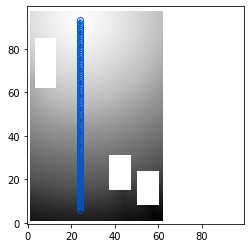

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  -0.051366508007049505 vy:  0.7627395391464232 v:  0.7644672149426268
vx:  0.0026701476890596543 vy:  0.9999964237213133 v:  0.9999999885720487
vx:  0.0026701476890596543 vy:  0.9999964237213133 v:  0.9999999885720487
vx:  0.0026701476890596543 vy:  0.9999964237213133 v:  0.9999999885720487
vx:  0.0026701476890596543 vy:  0.9999964237213133 v:  0.9999999885720487
vx:  0.0026701474562291216 vy:  0.9999964237213134 v:  0.9999999885714271
vx:  0.0019761472940446057 vy:  0.9999980330467223 v:  0.9999999856277205
vx:  0.0019761472940446057 vy:  0.9999980330467223 v:  0.9999999856277205
vx:  0.0019761472940446057 vy:  0.9999980330467223 v:  0.9999999856277205
vx:  0.0019761472940446057 vy:  0.9999980330467223 v:  0.9999999856277205
vx:  0.0019761472940446057 vy:  0.9999980330467223 v:  0.9999999856277205
vx:  0.001462524407542909 vy:  0.999998927116394 v:  0.9999999966057909
vx:  0.001462524407542909 vy:  0.999998927116394 v:  0.9999999966057909
vx:  0.

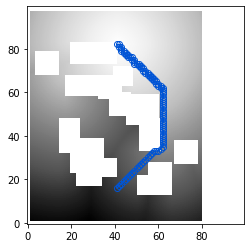

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  0.07407805323600772 vy:  0.263915091753006 v:  0.2741144535157429
vx:  0.46756094694137545 vy:  0.46643245220184343 v:  0.6604335481876589
vx:  0.5755788683891296 vy:  0.7076183557510375 v:  0.9121484370056844
vx:  0.5884632468223571 vy:  0.6890351772308352 v:  0.9061227666945793
vx:  0.5859546661376951 vy:  0.6614736914634707 v:  0.8836799846476373
vx:  0.5827088356018066 vy:  0.6350147724151612 v:  0.8618545981045135
vx:  0.5786864161491395 vy:  0.6096142530441283 v:  0.8405400084172588
vx:  0.5738462209701535 vy:  0.5852296352386477 v:  0.8196299233698626
vx:  0.5681450366973879 vy:  0.5618204474449155 v:  0.7990187719265933
vx:  0.7087796330451963 vy:  0.5393475890159609 v:  0.890653911458886
vx:  0.6918209195137023 vy:  0.6002917885780337 v:  0.9159510991919816
vx:  0.6918209195137022 vy:  0.6002918481826784 v:  0.9159511382553985
vx:  0.6918209791183471 vy:  0.6002918481826783 v:  0.9159511832749845
vx:  0.6918208599090576 vy:  0.60029190778

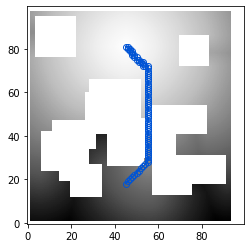

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -0.004015788435935969 vy:  0.2408807575702667 v:  0.24091422939375706
idx:  0
vx:  0.11505691707134244 vy:  0.3411402702331543 v:  0.36002052461034956
vx:  0.27360838651657104 vy:  0.32749468088150024 v:  0.4267485385773184
vx:  0.26207712292671204 vy:  0.38272988796234125 v:  0.4638605237581758
vx:  0.2711237967014312 vy:  0.3993248045444488 v:  0.4826680149567208
vx:  0.27119576930999756 vy:  0.3994308710098266 v:  0.4827961951044251
vx:  0.2655848562717438 vy:  0.391166865825653 v:  0.47280739503602015
vx:  0.2572188377380371 vy:  0.378844916820526 v:  0.4579137489615899
vx:  0.2476986050605774 vy:  0.36482301354408264 v:  0.4409653389557299
vx:  0.23784357309341433 vy:  0.35030797123908997 v:  0.4234208780580965
vx:  0.22804902493953705 vy:  0.3358822166919708 v:  0.4059842623375759
vx:  0.21849705278873444 vy:  0.3218134641647339 v:  0.3889792639654066
vx:  0.20926572382450107 vy:  0.30821713805198675 v:  0.3725452286055343
vx:  0.20038416981

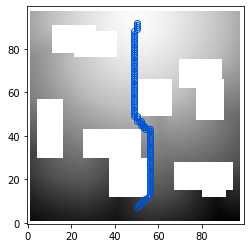

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  0.07010533660650253 vy:  0.03760034218430519 v:  0.0795521461249655
idx:  0
vx:  0.1410482525825501 vy:  0.09833572804927822 v:  0.17194337721346656
idx:  0
vx:  0.15691614151000974 vy:  0.16283108294010162 v:  0.22613411294591457
idx:  0
vx:  0.14939947426319117 vy:  0.19267934560775762 v:  0.24381454660038565
idx:  0
vx:  0.1432354003190994 vy:  0.2038576900959015 v:  0.24914722096746186
idx:  0
vx:  0.20106166601181036 vy:  0.2575466930866241 v:  0.3267355087211987
vx:  0.26894775032997126 vy:  0.3876445889472962 v:  0.4718063371211442
vx:  0.36631244421005266 vy:  0.5279799699783325 v:  0.6426100337541142
vx:  0.4334632754325869 vy:  0.6247674226760864 v:  0.7604109044365858
vx:  0.4204949140548705 vy:  0.6060752868652344 v:  0.737660644263193
vx:  0.40637844800949074 vy:  0.5857290029525759 v:  0.7128968424017749
vx:  0.3911200165748595 vy:  0.563736081123352 v:  0.6861291689804718
vx:  0.3747631609439851 vy:  0.5401604175567626 v:  0.6574349

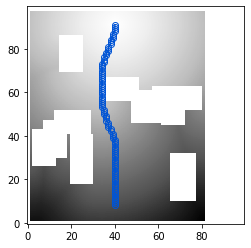

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -0.00848505832254881 vy:  0.6711878180503845 v:  0.6712414493414223
vx:  0.0004389849491417963 vy:  0.9999998807907104 v:  0.9999999771446101
vx:  0.0004389849491417963 vy:  0.9999998807907104 v:  0.9999999771446101
vx:  0.0004389849491417963 vy:  0.9999998807907104 v:  0.9999999771446101
vx:  0.0004389849491417963 vy:  0.9999998807907104 v:  0.9999999771446101
vx:  0.0004389849491417963 vy:  0.9999998807907104 v:  0.9999999771446101
vx:  0.00032542779808858446 vy:  0.999999940395355 v:  0.9999999933469826
vx:  0.00032542779808858446 vy:  0.999999940395355 v:  0.9999999933469826
vx:  0.00032542782719247043 vy:  0.9999999403953552 v:  0.9999999933469923
vx:  0.00032542779808858446 vy:  0.999999940395355 v:  0.9999999933469826
vx:  0.00024538679281255193 vy:  0.9999999403953552 v:  0.9999999705026956
vx:  0.00024538679281255193 vy:  0.9999999403953552 v:  0.9999999705026956
vx:  0.00024538679281255193 vy:  0.9999999403953552 v:  0.9999999705026956
v

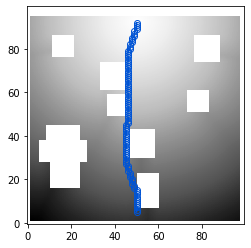

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -0.3860728442668916 vy:  0.42928344011306757 v:  0.5773530228860304
vx:  0.018486917018890492 vy:  0.9371345639228821 v:  0.9373168925181034
vx:  0.018486917018890492 vy:  0.9371345639228821 v:  0.9373168925181034
vx:  0.018486917018890492 vy:  0.9371345639228821 v:  0.9373168925181034
vx:  0.019723214209079354 vy:  0.9246269464492798 v:  0.9248372804330806
vx:  0.019629612565041032 vy:  0.8876417279243469 v:  0.8878587493751323
vx:  0.019482366740703916 vy:  0.8521360754966736 v:  0.8523587588431834
vx:  0.014231495559215435 vy:  0.8180506229400635 v:  0.8181744050986182
vx:  -0.2511611282825467 vy:  0.7853286862373352 v:  0.8245138311680531
vx:  -0.2331125140190124 vy:  0.9078664183616638 v:  0.9373168502598787
vx:  -0.2331125140190124 vy:  0.9078664183616638 v:  0.9373168502598787
vx:  -0.2331125140190124 vy:  0.9078664183616638 v:  0.9373168502598787
vx:  -0.1765801161527637 vy:  0.9205337166786193 v:  0.9373168412883
vx:  -0.15671388804912556

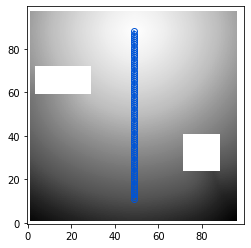

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  0.29751828312873846 vy:  0.599255383014679 v:  0.6690471903146606
vx:  0.20205701887607583 vy:  0.8122787475585938 v:  0.8370327368821631
vx:  0.14265628159046184 vy:  0.8247866630554199 v:  0.8370327677166002
vx:  0.11296124011278152 vy:  0.8293753862380981 v:  0.8370327192322962
vx:  0.09881553798913967 vy:  0.8311794400215149 v:  0.8370327186332457
vx:  0.09265281260013569 vy:  0.8318889737129213 v:  0.8370327402604114
vx:  0.09050317108631123 vy:  0.8321256041526796 v:  0.8370327622400094
vx:  0.09029508382081991 vy:  0.8321481943130493 v:  0.8370327469464247
vx:  0.09095069020986551 vy:  0.8320767283439636 v:  0.8370326815012931
vx:  0.11402681469917297 vy:  0.8292295336723328 v:  0.8370326958876063
vx:  0.14355203509330755 vy:  0.8246312141418457 v:  0.8370327509222591
vx:  0.15758515894412994 vy:  0.8220648169517517 v:  0.8370326430847029
vx:  0.16406008601188662 vy:  0.8207973241806031 v:  0.8370328304220007
vx:  0.1657422482967376 vy:  0.

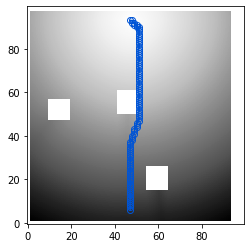

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  0.12411585450172441 vy:  0.5102716088294982 v:  0.5251493693380367
vx:  0.01665439456701273 vy:  0.8106492161750793 v:  0.8108202763520805
vx:  -0.007536038290709229 vy:  0.9999716281890869 v:  1.000000024528126
vx:  -0.007536038290709229 vy:  0.9999716281890869 v:  1.000000024528126
vx:  -0.007536038290709229 vy:  0.9999716281890869 v:  1.000000024528126
vx:  -0.007536038290709229 vy:  0.9999716281890869 v:  1.000000024528126
vx:  -0.005621386691927882 vy:  0.9999842047691345 v:  1.0000000048880493
vx:  -0.005621386691927882 vy:  0.9999842047691345 v:  1.0000000048880493
vx:  -0.005621386691927882 vy:  0.9999842047691345 v:  1.0000000048880493
vx:  -0.005621386691927882 vy:  0.9999842047691345 v:  1.0000000048880493
vx:  -0.005621386691927882 vy:  0.9999842047691345 v:  1.0000000048880493
vx:  -0.0041931653395294866 vy:  0.9999912381172181 v:  1.0000000294733853
vx:  -0.0041931653395294866 vy:  0.9999912381172181 v:  1.0000000294733853
vx:  -0.0

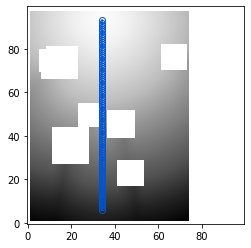

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  -0.3438718318939209 vy:  0.5137680768966676 v:  0.6182276875134121
vx:  -0.26211410760879505 vy:  0.7924877405166626 v:  0.8347099042642061
vx:  -0.19129788875579862 vy:  0.8124935030937194 v:  0.8347098746342526
vx:  -0.1628628373146055 vy:  0.8186673521995544 v:  0.8347098521855322
vx:  -0.15664859116077412 vy:  0.8198791146278381 v:  0.8347098560072135
vx:  -0.1617131531238557 vy:  0.818895161151886 v:  0.8347097872022544
vx:  -0.1697551012039183 vy:  0.8172659873962402 v:  0.83470982295616
vx:  -0.17738842964172352 vy:  0.8156432509422302 v:  0.8347098704210744
vx:  -0.18301865458488442 vy:  0.8143983483314514 v:  0.8347098284380371
vx:  -0.1756978929042814 vy:  0.8160091042518616 v:  0.8347098943902186
vx:  -0.1686699837446215 vy:  0.8174906969070433 v:  0.8347098914868413
vx:  -0.16192319989204385 vy:  0.8188536763191223 v:  0.8347098093856455
vx:  -0.15544627606868744 vy:  0.8201079368591309 v:  0.8347098734548207
vx:  -0.14922840893268602

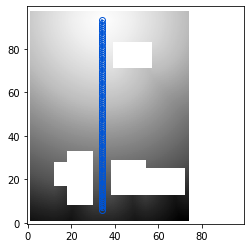

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  0.09828279912471785 vy:  0.4594294428825378 v:  0.46982435184986815
vx:  0.0007438436150550287 vy:  0.8990282416343689 v:  0.8990285493573098
vx:  -0.006104154512286353 vy:  0.9999813437461854 v:  0.999999974271368
vx:  -0.006104154512286353 vy:  0.9999813437461854 v:  0.999999974271368
vx:  -0.006104154512286353 vy:  0.9999813437461854 v:  0.999999974271368
vx:  -0.004429306369274744 vy:  0.9999901652336121 v:  0.9999999746594295
vx:  -0.004429306369274744 vy:  0.9999901652336121 v:  0.9999999746594295
vx:  -0.004429305903613845 vy:  0.9999901652336121 v:  0.999999974657367
vx:  -0.004429306369274744 vy:  0.9999901652336121 v:  0.9999999746594295
vx:  -0.004429305903613845 vy:  0.9999901652336121 v:  0.999999974657367
vx:  -0.0032139897812160645 vy:  0.9999948143959045 v:  0.9999999792745065
vx:  -0.0032139897812160645 vy:  0.9999948143959045 v:  0.9999999792745065
vx:  -0.0032139897812160645 vy:  0.9999948143959045 v:  0.9999999792745065
vx:  -

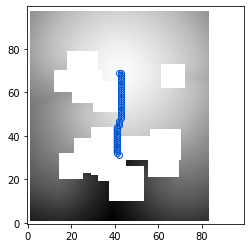

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -0.1357452869415282 vy:  0.36856859922409063 v:  0.3927716833745098
vx:  0.03441631793975822 vy:  0.44573074579238886 v:  0.4470574691079098
vx:  -0.14674590528011328 vy:  0.5065656304359436 v:  0.5273927366350858
vx:  -0.07347683608531969 vy:  0.5790695548057556 v:  0.5837125960128365
vx:  -0.040943522006273186 vy:  0.6281698346138 v:  0.6295027506794606
vx:  -0.03469336777925475 vy:  0.6264220476150513 v:  0.6273820299515281
vx:  -0.013298641890287427 vy:  0.5811545252799987 v:  0.5813066627259201
vx:  0.00804515182971946 vy:  0.5374472141265869 v:  0.5375074254746558
vx:  0.1176479831337929 vy:  0.5206770300865172 v:  0.5338029763828273
vx:  0.13073132932186127 vy:  0.5371053814887999 v:  0.5527864608422408
vx:  0.13596008718013766 vy:  0.5425308346748351 v:  0.559307475257576
vx:  0.13952514529228224 vy:  0.5470044612884521 v:  0.564518508853609
vx:  0.1413952112197875 vy:  0.5493528842926025 v:  0.5672576109991737
vx:  0.1423694789409637 vy: 

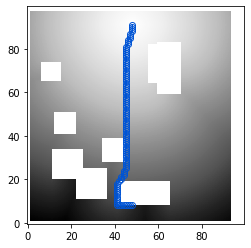

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  -0.4632361233234406 vy:  0.03451862186193452 v:  0.4645204421841703
vx:  -0.6058349609375 vy:  0.1397520303726197 v:  0.6217448269888635
vx:  -0.5686380863189697 vy:  0.1311717033386229 v:  0.5835711515910085
vx:  -0.5299167633056641 vy:  0.12223929166793818 v:  0.5438328975520242
vx:  -0.49030560255050665 vy:  0.1131024211645126 v:  0.5031816188670749
vx:  -0.3724215626716614 vy:  0.08590899407863614 v:  0.38220174725713296
vx:  -0.34971338510513306 vy:  0.08067066967487332 v:  0.3588972118413344
vx:  -0.32777622342109686 vy:  0.07561002671718592 v:  0.33638390089356296
vx:  -0.30669233202934265 vy:  0.07074667513370517 v:  0.31474637181081305
vx:  -0.28652334213256836 vy:  0.0660950839519501 v:  0.29404793097288096
vx:  -0.3439265787601471 vy:  0.11381030082702633 v:  0.3622682378459336
vx:  -0.1458859443664551 vy:  0.11841898411512372 v:  0.1878982824896235
idx:  0
vx:  -0.23620316386222848 vy:  0.19173555076122284 v:  0.30422763852785667
vx: 

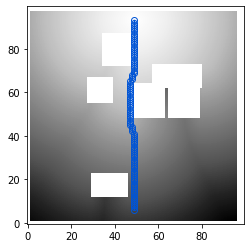

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  0.24396955966949474 vy:  0.5184809565544128 v:  0.5730127820170385
vx:  -0.012522146105766309 vy:  0.9999216198921203 v:  1.0000000250353878
vx:  -0.012522146105766309 vy:  0.9999216198921203 v:  1.0000000250353878
vx:  -0.012522146105766309 vy:  0.9999216198921203 v:  1.0000000250353878
vx:  -0.012522146105766309 vy:  0.9999216198921203 v:  1.0000000250353878
vx:  -0.012522146105766309 vy:  0.9999216198921203 v:  1.0000000250353878
vx:  -0.009308684617281116 vy:  0.9999566674232483 v:  0.9999999941667563
vx:  -0.009308684617281116 vy:  0.9999566674232483 v:  0.9999999941667563
vx:  -0.009308684617281116 vy:  0.9999566674232483 v:  0.9999999941667563
vx:  -0.009308684617281116 vy:  0.9999566674232483 v:  0.9999999941667563
vx:  -0.009308684617281116 vy:  0.9999566674232483 v:  0.9999999941667563
vx:  -0.006919787265360418 vy:  0.9999760389328004 v:  0.9999999809477655
vx:  -0.006919787265360418 vy:  0.9999760389328004 v:  0.9999999809477655
vx:  -

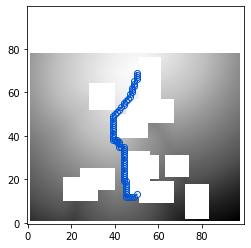

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  -0.38898345828056335 vy:  0.008828297257423429 v:  0.3890836280908928
vx:  -0.49244230985641474 vy:  0.07428956031799308 v:  0.4980144248000874
vx:  -0.4624248147010803 vy:  0.06976149976253512 v:  0.4676573276454103
vx:  -0.43266201019287115 vy:  0.0652715861797332 v:  0.4375577619315586
vx:  -0.40342867374420166 vy:  0.060860771685838644 v:  0.4079935395679707
vx:  -0.38519737124443054 vy:  0.13935257494449607 v:  0.4096292896721144
vx:  -0.31126254796981817 vy:  0.17553099989891055 v:  0.3573450792919565
vx:  -0.3106541335582733 vy:  0.2434217035770416 v:  0.39466456196267563
vx:  -0.15053784847259516 vy:  0.6989349722862244 v:  0.7149627537903658
vx:  -0.16376745700836184 vy:  0.7603591084480286 v:  0.777795444686369
vx:  -0.20052437484264365 vy:  0.7570180296897888 v:  0.7831259938103466
vx:  -0.15949644148349765 vy:  0.7575342655181885 v:  0.7741429314280923
vx:  -0.3001153171062469 vy:  0.7447211146354674 v:  0.8029188888958063
vx:  -0.353

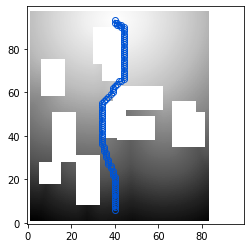

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  0.0034537436440588154 vy:  0.6401297450065613 v:  0.6401390620695819
vx:  -0.00015047338092682994 vy:  0.8434746861457825 v:  0.8434746995677846
vx:  -0.00015047338092682994 vy:  0.8434746861457825 v:  0.8434746995677846
vx:  -0.00015047338092682994 vy:  0.8434746861457825 v:  0.8434746995677846
vx:  -0.00015047339547918925 vy:  0.8434746861457825 v:  0.8434746995677873
vx:  -0.00015047339547918925 vy:  0.8434746861457825 v:  0.8434746995677873
vx:  -0.00015047338092682994 vy:  0.8434746861457825 v:  0.8434746995677846
vx:  -0.0001114886763387557 vy:  0.8434746861457822 v:  0.8434746935139493
vx:  -0.0001114886763387557 vy:  0.8434746861457822 v:  0.8434746935139493
vx:  -0.0001114886763387557 vy:  0.8434746861457822 v:  0.8434746935139493
vx:  -0.0001114886763387557 vy:  0.8434746861457822 v:  0.8434746935139493
vx:  -0.0001114886763387557 vy:  0.8434746861457822 v:  0.8434746935139493
vx:  -0.26552480459213257 vy:  0.8005911111831665 v:  0.84347

vx:  0.00941896438598655 vy:  0.6558972597122192 v:  0.6559648863987331
vx:  0.009042024612426813 vy:  0.6296614408493042 v:  0.6297263598591959
vx:  0.008629241026938073 vy:  0.6009103059768677 v:  0.6009722619471831
vx:  0.008145317435264532 vy:  0.5672142505645752 v:  0.567272731796315
vx:  0.007647598627954805 vy:  0.532556414604187 v:  0.5326113221673391
vx:  0.00714245066046712 vy:  0.49737638235092163 v:  0.4974276634063765
vx:  0.006636456586420425 vy:  0.4621397256851196 v:  0.46218737392137943
vx:  0.0061362464912236014 vy:  0.4273082613945007 v:  0.42735231809011165
vx:  0.005648039747029571 vy:  0.393311083316803 v:  0.39335163481651014
vx:  0.005177156534046046 vy:  0.36052083969116216 v:  0.3605580103137339
vx:  0.0062847137451171875 vy:  0.4376518726348877 v:  0.4376969947894114
vx:  0.0037199286743998666 vy:  0.2590431272983551 v:  0.25906983550744467


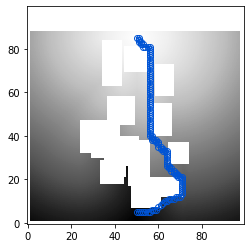

vx:  -0.0 vy:  0.0 v:  0.0
idx:  0
vx:  0.4472135305404663 vy:  0.12594337761402136 v:  0.4646091650659687
vx:  0.9134970903396606 vy:  0.26477089524269104 v:  0.9510944017428775
vx:  0.908131003379822 vy:  0.26321539282798756 v:  0.9455074099769045
vx:  0.901862382888794 vy:  0.2613985836505892 v:  0.9389808183367686
vx:  0.8944968581199646 vy:  0.25926387310028054 v:  0.9313121845447134
vx:  0.9365423917770388 vy:  0.2714502215385436 v:  0.9750881367183076
vx:  0.9338002800941467 vy:  0.27065560221672064 v:  0.9722332117939618
vx:  0.9305764436721802 vy:  0.269720822572708 v:  0.9688765863859342
vx:  0.9267570376396179 vy:  0.26861441135406494 v:  0.964900154835541
vx:  0.9221936464309695 vy:  0.2672911286354064 v:  0.9601487743911552
vx:  0.91669100522995 vy:  0.2656961679458618 v:  0.9544196418403237
vx:  0.9099923372268677 vy:  0.2637563049793242 v:  0.9474457463242756
vx:  0.7822157144546509 vy:  0.22671888768672954 v:  0.8144095271874634
vx:  0.7967236042022707 vy:  0.3746051490

vx:  -0.12262871861457825 vy:  0.9489963650703432 v:  0.9568865677528229
vx:  -0.12227356433868392 vy:  0.911036491394043 v:  0.9192052617275721
vx:  -0.12156602740287786 vy:  0.8745951056480408 v:  0.8830033396550802
vx:  -0.12047830224037165 vy:  0.839611291885376 v:  0.8482111428012205
vx:  -0.11898234486579884 vy:  0.8060267567634583 v:  0.814761272403385
vx:  -0.0815420150756836 vy:  0.7737857103347778 v:  0.7780703218481603
vx:  -0.0803827047348023 vy:  0.7428343296051025 v:  0.7471708107657475
vx:  -0.0790151953697204 vy:  0.7131209373474121 v:  0.7174851025509636
vx:  -0.07743680477142328 vy:  0.684596061706543 v:  0.6889617017202889
vx:  -0.0756465196609496 vy:  0.6572122573852539 v:  0.6615514697997698
vx:  -0.07364508509635925 vy:  0.6309237480163574 v:  0.635207347540831
vx:  -0.07143527269363392 vy:  0.6056867837905884 v:  0.6098848073557832
vx:  -0.06902205944061279 vy:  0.5814592838287354 v:  0.5855415813074673
vx:  -0.06641280651092527 vy:  0.5582009553909302 v:  0.5621

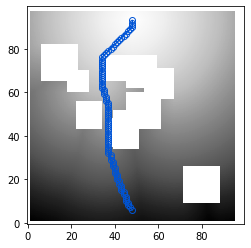

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  0.02653235942125315 vy:  0.6368062496185303 v:  0.6373587417221768
vx:  -0.2053724378347398 vy:  0.7911351323127747 v:  0.8173571042094976
vx:  -0.2053724378347398 vy:  0.7911351323127747 v:  0.8173571042094976
vx:  -0.2053724378347398 vy:  0.7911351323127747 v:  0.8173571042094976
vx:  -0.2053724378347398 vy:  0.7911351323127747 v:  0.8173571042094976
vx:  -0.2053724378347398 vy:  0.7911351323127747 v:  0.8173571042094976
vx:  -0.2053724378347398 vy:  0.7911351323127747 v:  0.8173571042094976
vx:  -0.33436840772628773 vy:  0.7458353638648987 v:  0.8173570958136345
vx:  -0.33436834812164307 vy:  0.7458353042602539 v:  0.8173570170412571
vx:  -0.33436834812164307 vy:  0.7458353042602539 v:  0.8173570170412571
vx:  -0.33436840772628773 vy:  0.7458353638648987 v:  0.8173570958136345
vx:  -0.33436834812164307 vy:  0.7458353042602539 v:  0.8173570170412571
vx:  -0.33436834812164307 vy:  0.7458353042602539 v:  0.8173570170412571
vx:  -0.334368348121643

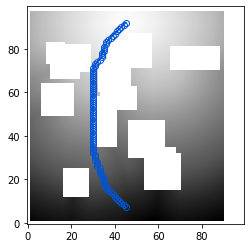

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  -0.23503664135932925 vy:  0.9401465654373169 v:  0.9690808982149308
vx:  -0.441873788833618 vy:  0.8624762892723083 v:  0.9690809021000814
vx:  -0.441873788833618 vy:  0.8624762892723083 v:  0.9690809021000814
vx:  -0.441873788833618 vy:  0.8624762892723083 v:  0.9690809021000814
vx:  -0.441873788833618 vy:  0.8624762892723083 v:  0.9690809021000814
vx:  -0.441873788833618 vy:  0.8624762892723083 v:  0.9690809021000814
vx:  -0.3462986350059509 vy:  0.9050938487052919 v:  0.9690808116824636
vx:  -0.3462986350059509 vy:  0.9050938487052919 v:  0.9690808116824636
vx:  -0.5345759987831116 vy:  0.8082984089851379 v:  0.969080913258984
vx:  -0.5345759987831116 vy:  0.8082984089851379 v:  0.969080913258984
vx:  -0.5345759987831117 vy:  0.8082982897758484 v:  0.9690808138279917
vx:  -0.5345759987831116 vy:  0.8082984089851379 v:  0.969080913258984
vx:  -0.4288870096206665 vy:  0.8690072298049928 v:  0.9690808183400935
vx:  -0.4288870096206665 vy:  0.8690

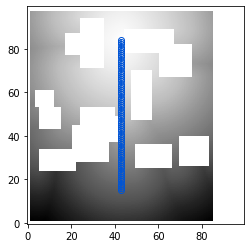

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  0.005344092845916748 vy:  0.6720750331878662 v:  0.6720962799798978
vx:  0.027073025703430287 vy:  0.9336130023002625 v:  0.9340054532950268
vx:  -0.0016753892414271276 vy:  0.9357385635375977 v:  0.9357400633832651
vx:  -0.0016753892414271276 vy:  0.9357385635375977 v:  0.9357400633832651
vx:  -0.0016753892414271276 vy:  0.9357385635375977 v:  0.9357400633832651
vx:  -0.0016753892414271276 vy:  0.9357385635375977 v:  0.9357400633832651
vx:  -0.002366756089031641 vy:  0.9357370734214783 v:  0.9357400665301118
vx:  -0.006447596941143274 vy:  0.9357178211212159 v:  0.9357400345556192
vx:  -0.006447537336498332 vy:  0.9357178807258606 v:  0.9357400937481526
vx:  -0.00644762674346544 vy:  0.9357178211212158 v:  0.9357400347609686
vx:  -0.006447686348110604 vy:  0.9357178211212158 v:  0.9357400351716706
vx:  -0.006447567604481896 vy:  0.9357178807258606 v:  0.9357400939567089
vx:  -0.00644762674346544 vy:  0.9357178211212158 v:  0.9357400347609686
vx:

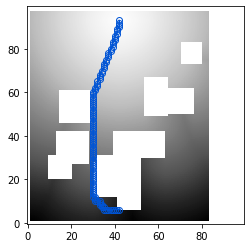

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  -0.571598768234253 vy:  0.3239524364471435 v:  0.6570162349036406
vx:  -0.8849294781684875 vy:  0.4388837814331057 v:  0.9877849740386689
vx:  -0.7170981168746946 vy:  0.6251024007797242 v:  0.951305797672761
vx:  -0.7126336097717284 vy:  0.6212104558944702 v:  0.945383039983741
vx:  -0.7073669433593749 vy:  0.6166195869445802 v:  0.938396348864002
vx:  -0.7011135816574096 vy:  0.6111682653427124 v:  0.9301004800270244
vx:  -0.6936389207839967 vy:  0.6046526432037352 v:  0.9201846398194501
vx:  -0.684647262096405 vy:  0.5968145132064818 v:  0.9082562615638791
vx:  -0.6684666872024535 vy:  0.5827096700668335 v:  0.8867909965086591
vx:  -0.6160009503364563 vy:  0.5369747877120972 v:  0.8171897536397952
vx:  -0.6018220186233519 vy:  0.5246150493621826 v:  0.7983800424091095
vx:  -0.5860298871994017 vy:  0.510848641395569 v:  0.7774299731208221
vx:  -0.5685175657272339 vy:  0.4955832362174988 v:  0.7541982276299971
vx:  -0.5468332171440125 vy:  0.476

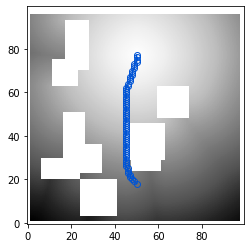

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  -0.21216413378715512 vy:  0.05184854567050934 v:  0.21840762659257287
idx:  0
vx:  -0.3144262433052063 vy:  0.2480893731117248 v:  0.4005149179868253
vx:  -0.24146860837936396 vy:  0.4046101570129395 v:  0.4711862349333883
vx:  -0.19158871471881866 vy:  0.5011108517646788 v:  0.5364870188214537
vx:  -0.16206964850425726 vy:  0.5593696832656859 v:  0.582375320152775
vx:  -0.16667492687702182 vy:  0.5799497961997986 v:  0.6034254695997249
vx:  -0.20298227667808535 vy:  -0.05327892303466791 v:  0.20985816230290605
idx:  0
vx:  -0.3075840771198273 vy:  0.06260435283184056 v:  0.3138905374348667
vx:  -0.3927751779556275 vy:  0.13357385993003842 v:  0.4148666249226182
vx:  -0.4580033421516419 vy:  0.18436726927757266 v:  0.4937188991753738
vx:  -0.48659259080886846 vy:  0.24422106146812436 v:  0.544441251463098
vx:  -0.4766905903816222 vy:  0.26921081542968756 v:  0.5474562832799499
vx:  -0.45762294530868536 vy:  0.24995292723178864 v:  0.5214357351627

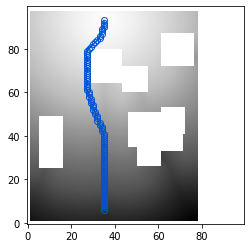

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  0.01740116998553276 vy:  0.5506987571716309 v:  0.5509736126778162
vx:  -0.04130068421363836 vy:  0.9294201135635375 v:  0.9303373012047693
vx:  0.0012888105120510418 vy:  0.9567406773567201 v:  0.9567415454246416
vx:  0.0012888105120510418 vy:  0.9567406773567201 v:  0.9567415454246416
vx:  0.0012888105120510418 vy:  0.9567406773567201 v:  0.9567415454246416
vx:  0.0012888106284665857 vy:  0.95674067735672 v:  0.9567415454247983
vx:  0.0009481206652711127 vy:  0.9567410349845886 v:  0.9567415047734564
vx:  0.0009481206652711127 vy:  0.9567410349845886 v:  0.9567415047734564
vx:  0.0009481206652711127 vy:  0.9567410349845886 v:  0.9567415047734564
vx:  0.0009481206652711127 vy:  0.9567410349845886 v:  0.9567415047734564
vx:  0.0009481206652711127 vy:  0.9567410349845886 v:  0.9567415047734564
vx:  0.0007003237260504447 vy:  0.9567412734031678 v:  0.956741529717633
vx:  0.0007003237260504447 vy:  0.9567412734031678 v:  0.956741529717633
vx:  0.000

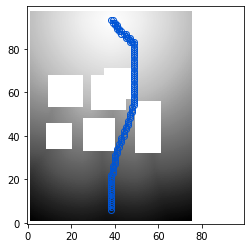

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  0.12836156785488134 vy:  0.628420352935791 v:  0.6413960025492109
vx:  0.06926596164703358 vy:  0.9069290757179261 v:  0.9095702951534094
vx:  -0.010301638394594193 vy:  0.9624982476234435 v:  0.9625533753677312
vx:  -0.010301638394594193 vy:  0.9624982476234435 v:  0.9625533753677312


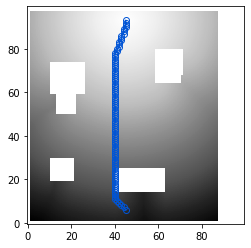

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -0.24253562092781075 vy:  0.3973743915557861 v:  0.4655426237018152
vx:  -0.3163032233715055 vy:  0.9437679052352906 v:  0.9953620386911554
vx:  -0.3024488687515262 vy:  0.9502574205398558 v:  0.9972284008691983
vx:  -0.30235412716865545 vy:  0.9499601125717162 v:  0.9969163624362813
vx:  -0.3022426962852479 vy:  0.9496100544929504 v:  0.9965489968144471
vx:  -0.30211025476455733 vy:  0.9491937756538389 v:  0.9961121572262311
vx:  -0.3000265955924989 vy:  0.9426469802856445 v:  0.9892417740393241
vx:  -0.2996826767921442 vy:  0.9415663480758669 v:  0.9881077343074638
vx:  -0.2992820739746098 vy:  0.9403080344200132 v:  0.986787190531663
vx:  -0.2988122403621676 vy:  0.9388316869735718 v:  0.9852378857189265
vx:  -0.29825645685195934 vy:  0.9370851516723632 v:  0.9834050516133729
vx:  -0.29759272933006264 vy:  0.9349998235702516 v:  0.9812166440835162
vx:  -0.29506129026412986 vy:  0.9270473122596741 v:  0.9728709493967937
vx:  -0.08566281944513315

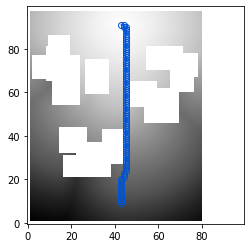

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  0.10059743374586083 vy:  0.7594893574714661 v:  0.7661226584488108
vx:  0.0747438594698906 vy:  0.8432750105857848 v:  0.8465809990821376
vx:  0.0835147723555566 vy:  0.8424515128135679 v:  0.8465809285847807
vx:  0.08477934449911134 vy:  0.8423252701759338 v:  0.8465810050022732
vx:  0.08477933704853075 vy:  0.8423251509666443 v:  0.8465808856461198
vx:  0.08477935194969172 vy:  0.8423252105712891 v:  0.8465809464433842
vx:  0.08477935194969172 vy:  0.8423253297805786 v:  0.8465810650534125
vx:  0.08477935940027265 vy:  0.8423252701759336 v:  0.8465810064945234
vx:  0.08477934449911151 vy:  0.8423253297805786 v:  0.8465810643072874
vx:  0.08477936685085324 vy:  0.8423252701759337 v:  0.8465810072406487
vx:  0.08477935194969172 vy:  0.8423252105712891 v:  0.8465809464433842
vx:  0.08477934449911129 vy:  0.842325210571289 v:  0.846580945697259
vx:  0.08477933704853041 vy:  0.842325210571289 v:  0.8465809449511338
vx:  0.084779351949692 vy:  0.8423

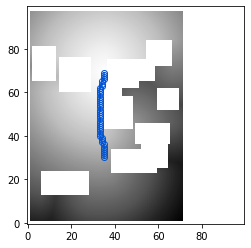

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  0.15933722257614139 vy:  0.37117326259613037 v:  0.40392813886201934
vx:  0.08516407757997518 vy:  0.6184712052345275 v:  0.6243072575377424
vx:  -0.011696131899952868 vy:  0.5937324166297914 v:  0.593847608447212
vx:  -0.10043446719646454 vy:  0.6103259921073914 v:  0.6185344766808955
vx:  -0.08850500732660288 vy:  0.7416576743125916 v:  0.7469198365210581
vx:  -0.08714341372251515 vy:  0.811035692691803 v:  0.8157039103591978
vx:  -0.09110091626644133 vy:  0.8478680849075316 v:  0.8527483018742109
vx:  -0.09327370673418041 vy:  0.8680899739265441 v:  0.8730865863130196
vx:  -0.09347786009311684 vy:  0.8699898719787597 v:  0.8749974215237476
vx:  -0.09347784519195562 vy:  0.8699897527694702 v:  0.8749973014047615
vx:  -0.09347784519195554 vy:  0.869989812374115 v:  0.8749973606682931
vx:  -0.09347786009311682 vy:  0.869989812374115 v:  0.8749973622602163
vx:  -0.09347786009311684 vy:  0.8699898719787597 v:  0.8749974215237476
vx:  -0.093477845191

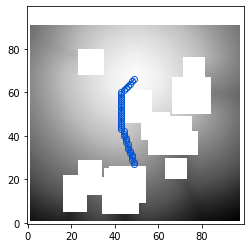

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  0.14273558557033525 vy:  0.48290032148361217 v:  0.5035535402289238
vx:  0.040506642311811336 vy:  0.5963416695594788 v:  0.5977157977871788
vx:  0.06247065216302866 vy:  0.6114978194236755 v:  0.6146805394199366
vx:  0.14309823513031 vy:  0.7591242790222168 v:  0.7724938678710724
vx:  0.11137763410806661 vy:  0.7578142285346985 v:  0.7659552091011267
vx:  0.10724893212318437 vy:  0.7275015711784363 v:  0.7353644467260141
vx:  0.11065138131380076 vy:  0.6984015703201294 v:  0.7071127785666688
vx:  0.11445234715938579 vy:  0.6704654693603516 v:  0.6801641606074882
vx:  0.1143867000937463 vy:  0.6436468362808228 v:  0.6537320299730226
vx:  0.11251091212034225 vy:  0.6179009675979614 v:  0.628060754310161
vx:  0.10974230617284766 vy:  0.5931849479675293 v:  0.6032509894392014
vx:  0.10615947842597961 vy:  0.5694575309753418 v:  0.5792682577564633
vx:  0.10191310942173001 vy:  0.5466791987419128 v:  0.5560974988337075
vx:  0.0978365689516068 vy:  0.52

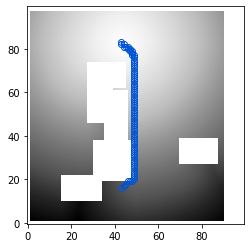

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  6.938893903907228e-18 vy:  0.14884603023529053 v:  0.14884603023529053
idx:  0
vx:  -0.1485961675643921 vy:  0.14289215207099917 v:  0.20615282714119262
idx:  0
vx:  0.31472674012184143 vy:  0.13717648386955256 v:  0.34332245582620247
vx:  0.49298998713493347 vy:  0.46190157532691956 v:  0.6755680518680497
vx:  0.4742107391357422 vy:  0.44430676102638256 v:  0.6498340734413839
vx:  0.4544640481472016 vy:  0.42580524086952215 v:  0.6227741759340168
vx:  0.43387377262115473 vy:  0.4065132141113281 v:  0.5945581921188505
vx:  0.41259655356407166 vy:  0.38657781481742864 v:  0.5654010284054743
vx:  0.39081758260726934 vy:  0.36617243289947504 v:  0.5355563775089512
vx:  0.3687415421009065 vy:  0.3454884886741637 v:  0.5053044831359725
vx:  0.3465850353240966 vy:  0.32472863793373113 v:  0.474941970144671
vx:  0.32456558942794805 vy:  0.30409792065620417 v:  0.4447677677037067
vx:  0.36414298415184015 vy:  0.34118202328681946 v:  0.49900429449163575
v

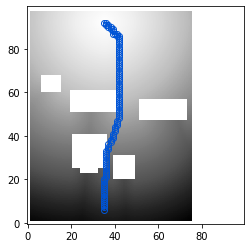

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  0.2183796614408492 vy:  0.4394407272338867 v:  0.49071155405479006
vx:  0.019312210381030953 vy:  0.649263322353363 v:  0.6495504778099452
vx:  0.04596438258886332 vy:  0.7977801561355591 v:  0.7991031860720194
vx:  0.029708536341786496 vy:  0.8130230903625487 v:  0.8135656965446861
vx:  0.02863122895360004 vy:  0.8130616545677185 v:  0.8135656097696051
vx:  0.028631225228309576 vy:  0.8130617141723633 v:  0.813565669206227
vx:  0.028631219640374073 vy:  0.8130617141723632 v:  0.8135656690095747
vx:  0.02863122895359993 vy:  0.8130617141723633 v:  0.8135656693373284
vx:  0.028631230816245024 vy:  0.8130617141723633 v:  0.8135656694028792
vx:  0.028631225228309576 vy:  0.8130617141723633 v:  0.813565669206227
vx:  0.028631227090954725 vy:  0.8130617141723633 v:  0.8135656692717778
vx:  0.02863122895359993 vy:  0.8130617141723633 v:  0.8135656693373284
vx:  0.028631221503019222 vy:  0.8130617141723632 v:  0.8135656690751254
vx:  0.028631221503019222

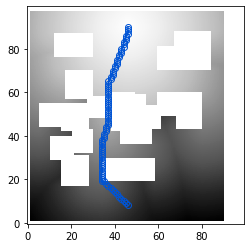

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  -0.02086150646209714 vy:  0.36704009771347046 v:  0.3676324737851406
vx:  -0.2611522078514099 vy:  0.4533864855766295 v:  0.5232205853836346
vx:  -0.5317254662513733 vy:  0.4352510571479798 v:  0.6871502413655068
vx:  -0.49344420433044434 vy:  0.574803590774536 v:  0.7575528699401816
vx:  -0.5363684296607971 vy:  0.6248052716255186 v:  0.8234517106593607
vx:  -0.5592976808547974 vy:  0.651515007019043 v:  0.8586534226220602
vx:  -0.5716021656990051 vy:  0.6658482551574706 v:  0.8775436939138933
vx:  -0.578240394592285 vy:  0.673581063747406 v:  0.8877349848785552
vx:  -0.5818440318107605 vy:  0.6777788400650024 v:  0.8932673918786365
vx:  -6.556510925292968e-07 vy:  7.748603820800783e-07 v:  1.0150305250839235e-06
idx:  0
vx:  -0.29533177614212036 vy:  0.2631075978279114 v:  0.3955331415115975
vx:  -0.4575245976448059 vy:  0.5391886830329894 v:  0.7071443935724097
vx:  -0.5275183320045473 vy:  0.6216757297515869 v:  0.8153258879509641
vx:  -1.716

vx:  0.007825680077075951 vy:  -0.16966161131858823 v:  0.1698419960548287
idx:  0


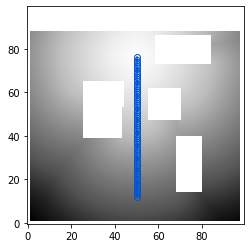

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  -0.0020424562972038984 vy:  0.4947059750556946 v:  0.4947101913075285
vx:  0.006387442350387629 vy:  0.7485255002975464 v:  0.7485527529943843
vx:  0.013384232297539711 vy:  0.8790847659111024 v:  0.8791866487448341
vx:  0.01301057636737829 vy:  0.9472572803497313 v:  0.9473466262530209
vx:  0.006112414412200451 vy:  0.9778634905815125 v:  0.9778825940889868
vx:  0.00019104545935993977 vy:  0.9929080009460449 v:  0.9929080193255762
vx:  -0.001928608282469102 vy:  0.9830397963523865 v:  0.9830416882017001
vx:  0.007439794950187151 vy:  0.951744318008423 v:  0.95177339604037
vx:  0.03307951241731677 vy:  0.9339680671691895 v:  0.9345536927504589
vx:  0.06518346816301368 vy:  0.9447110891342162 v:  0.946957193570499
vx:  0.07779222726821905 vy:  0.9738799333572389 v:  0.9769819625864391
vx:  0.07728491723537428 vy:  0.9721918106079102 v:  0.9752588759120141
vx:  0.07227227091789235 vy:  0.9555118680000306 v:  0.9582412071250835
vx:  0.06197009235620

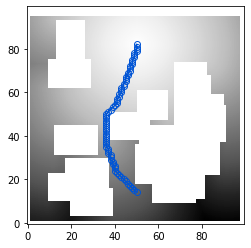

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -0.20534285902976993 vy:  0.30787801742553705 v:  0.37007372693613266
vx:  -0.44630551338195795 vy:  0.7251096963882447 v:  0.8514532770923989
vx:  -0.5215222835540773 vy:  0.8440597057342529 v:  0.9921805677837341
vx:  -0.5215222835540773 vy:  0.8440597057342529 v:  0.9921805677837341
vx:  -0.40836840867996227 vy:  0.9042441248893737 v:  0.9921805252093764
vx:  -0.4083684384822846 vy:  0.904244065284729 v:  0.9921804831537016
vx:  -0.4083684086799622 vy:  0.9042440652847289 v:  0.9921804708874579
vx:  -0.4083684086799622 vy:  0.9042440652847289 v:  0.9921804708874579
vx:  -0.4083684086799622 vy:  0.9042440652847289 v:  0.9921804708874579
vx:  -0.4083684384822846 vy:  0.904244065284729 v:  0.9921804831537016
vx:  -0.4083683788776399 vy:  0.9042440056800841 v:  0.9921804042992965
vx:  -0.4083683490753175 vy:  0.904244065284729 v:  0.992180446354973
vx:  -0.40836840867996227 vy:  0.9042441248893737 v:  0.9921805252093764
vx:  -0.4080920815467835 vy:

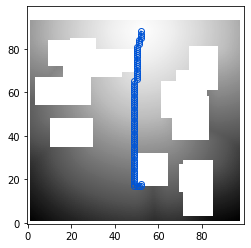

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  -0.06794419884681702 vy:  0.02507464960217477 v:  0.07242342307297864
idx:  0
vx:  -0.2225731462240219 vy:  0.17944005131721497 v:  0.2858977744523111
vx:  -0.3772266209125519 vy:  0.7175933122634888 v:  0.8107034509180203
vx:  -0.2543883621692658 vy:  0.8727871179580688 v:  0.9091043900898914
vx:  -0.16731983423233043 vy:  0.9641094207763673 v:  0.9785207724710175
vx:  -0.11838388442993159 vy:  0.9624170064926147 v:  0.9696706855829587
vx:  -0.09252469986677192 vy:  0.9583786129951477 v:  0.9628345579236026
vx:  -0.07986806333065055 vy:  0.9707171916961671 v:  0.9739973171393657
vx:  -0.07258795946836477 vy:  0.9677101373672485 v:  0.9704287309344876
vx:  -0.06859734654426569 vy:  0.9638676643371582 v:  0.96630557812096
vx:  -0.06630877405405045 vy:  0.9591061472892761 v:  0.9613955769009079
vx:  -0.06597882509231567 vy:  0.970545828342438 v:  0.9727859015597787
vx:  -0.0646678656339646 vy:  0.958785355091095 v:  0.9609637297956721
vx:  -0.06402

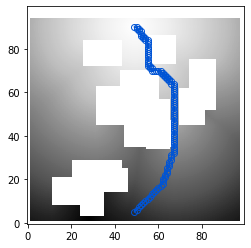

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  0.2121439576148989 vy:  0.5537927746772766 v:  0.5930358303148883
vx:  0.3858475089073181 vy:  0.7665898203849792 v:  0.8582180683531766
vx:  0.3858475089073181 vy:  0.7665898203849792 v:  0.8582180683531766
vx:  0.3858475089073181 vy:  0.7665898203849792 v:  0.8582180683531766
vx:  0.5340473651885986 vy:  0.6718121767044068 v:  0.8582180311745947
vx:  0.5340473651885986 vy:  0.6718121767044068 v:  0.8582180311745947
vx:  0.5340474247932432 vy:  0.6718121767044068 v:  0.8582180682650581
vx:  0.4401917457580571 vy:  0.7367289066314694 v:  0.8582180695487169
vx:  0.4401917457580571 vy:  0.7367289066314694 v:  0.8582180695487169
vx:  0.44019180536270147 vy:  0.7367289066314697 v:  0.8582181001207533
vx:  0.44019180536270147 vy:  0.7367289066314697 v:  0.8582181001207533
vx:  0.4401917457580571 vy:  0.7367289066314694 v:  0.8582180695487169
vx:  0.44019180536270147 vy:  0.7367289066314697 v:  0.8582181001207533
vx:  0.44019180536270147 vy:  0.73672890

vx:  -0.2684531211853028 vy:  0.5575870275497438 v:  0.6188459998787175
vx:  -0.2673614919185638 vy:  0.5553197264671325 v:  0.6163295919915343
vx:  -0.2493621855974198 vy:  0.5179345607757568 v:  0.5748371150612129
vx:  -0.24652767181396487 vy:  0.5120471119880677 v:  0.5683028575199448
vx:  -0.23163940012454987 vy:  0.4811236858367921 v:  0.5339820341202891
vx:  -0.22708752751350414 vy:  0.471669226884842 v:  0.523488877381689
vx:  -0.2149349004030228 vy:  0.44642788171768183 v:  0.49547438378405984
vx:  -0.20906373858451852 vy:  0.4342331886291504 v:  0.4819399432480931
vx:  -0.19912086427211761 vy:  0.41358157992362976 v:  0.4590194351447451
vx:  -0.19250448048114768 vy:  0.3998388648033142 v:  0.44376693524024474
vx:  -0.18416838347911832 vy:  0.3825246691703797 v:  0.4245504869826674
vx:  -0.17738027870655054 vy:  0.3684253692626954 v:  0.4089022083461607
vx:  -0.17012055218219763 vy:  0.35334670543670654 v:  0.39216692430360633
vx:  -0.1635537892580032 vy:  0.3397072851657868 v:

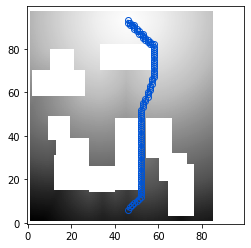

vx:  -0.0 vy:  0.0 v:  0.0
idx:  0
vx:  0.24253562092781067 vy:  0.41290861368179316 v:  0.4788705990885836
vx:  0.44805836677551275 vy:  0.8374731540679932 v:  0.9497987070017165
vx:  0.39732736349105846 vy:  0.8978893756866455 v:  0.9818728862483727
vx:  0.3965257108211518 vy:  0.8960778117179871 v:  0.9798918736245933
vx:  0.3955887258052826 vy:  0.8939605355262756 v:  0.9775765336088386
vx:  0.3873648941516875 vy:  0.8753762841224672 v:  0.9572539892970968
vx:  0.3718703985214234 vy:  0.8403611779212952 v:  0.9189638201005244
vx:  0.35699561238288874 vy:  0.8067467212677001 v:  0.8822052706353651
vx:  0.34271574020385737 vy:  0.7744768857955933 v:  0.8469170710377246
vx:  0.329007089138031 vy:  0.7434977889060973 v:  0.8130403598907843
vx:  0.31584694981575007 vy:  0.7137578725814819 v:  0.7805187995045064
vx:  0.30321308970451355 vy:  0.6852075457572937 v:  0.7492980438589781
vx:  0.2910845279693603 vy:  0.6577991843223572 v:  0.719326052161538
vx:  0.279441237449646 vy:  0.631487

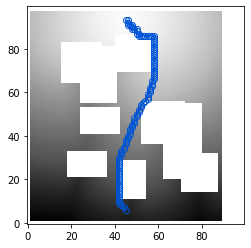

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  1.3877787807814457e-17 vy:  0.27145916223525995 v:  0.27145916223525995
vx:  1.3877787807814457e-17 vy:  0.26060083508491516 v:  0.26060083508491516
vx:  1.3877787807814457e-17 vy:  0.2501767873764038 v:  0.2501767873764038
vx:  2.0816681711721685e-17 vy:  0.24016970396041867 v:  0.24016970396041867
idx:  0
vx:  -0.254774272441864 vy:  0.23056295514106756 v:  0.34361199947275284
vx:  -0.23866988718509669 vy:  0.7263865470886232 v:  0.7645918720731206
vx:  -0.27542030811309826 vy:  0.9077557325363159 v:  0.9486183721990933
vx:  -0.2737681865692138 vy:  0.902310609817505 v:  0.9429281290568405
vx:  -0.2718482613563537 vy:  0.8959828615188598 v:  0.9363155265923965
vx:  -0.269605278968811 vy:  0.8885895013809204 v:  0.9285894186411146
vx:  -0.2669707834720611 vy:  0.8799066543579102 v:  0.919515698403794
vx:  -0.2680862247943879 vy:  0.8835836648941039 v:  0.9233581736207261
vx:  -0.26581162214279164 vy:  0.8760864734649657 v:  0.9155235264341721
vx

vx:  -0.0003100834437645937 vy:  0.04159841686487197 v:  0.04159957256277715
idx:  0
vx:  -0.003776758909225464 vy:  0.5066294074058533 v:  0.5066434844703566
vx:  -0.018618915230035803 vy:  0.38491904735565174 v:  0.38536909193852814
vx:  -0.1553809940814972 vy:  0.47096744179725647 v:  0.4959370772132352


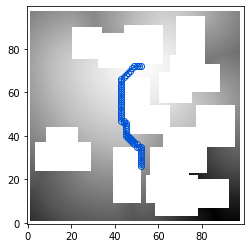

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  0.17817513644695282 vy:  0.44746077060699463 v:  0.48163006600511943
vx:  0.026517761871218654 vy:  0.5758363604545593 v:  0.5764466200058873
vx:  -0.019743300974368855 vy:  0.5528029203414917 v:  0.5531553729933807
vx:  -0.13465571403503412 vy:  0.5306907892227172 v:  0.5475078767361391
vx:  -0.12922973930835713 vy:  0.5093066096305847 v:  0.5254460468355497
vx:  -0.1240664124488831 vy:  0.4889574050903321 v:  0.5044519984008463
vx:  -0.11910796165466304 vy:  0.4694156646728515 v:  0.48429100009166354
vx:  -0.11434745043516162 vy:  0.4506539106369018 v:  0.4649347121837155
vx:  -0.10977691411972047 vy:  0.4326412081718445 v:  0.446351191195948
vx:  -0.10538890212774285 vy:  0.41534751653671265 v:  0.4285094866918418
vx:  -0.10117607563734053 vy:  0.3987444043159485 v:  0.41138023561500064
vx:  -0.09713155031204213 vy:  0.3828043341636658 v:  0.3949350532942199
vx:  -0.0932486951351166 vy:  0.3675008714199066 v:  0.37914668617672587
vx:  -0.08952

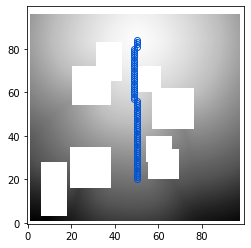

vx:  -0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -0.23155173659324657 vy:  0.7544904947280884 v:  0.789222473928856
vx:  0.0162251945585013 vy:  0.97225421667099 v:  0.9723895920735585
vx:  0.01169453281909219 vy:  0.972319185733795 v:  0.9723895109696973
vx:  0.01169453281909219 vy:  0.972319185733795 v:  0.9723895109696973
vx:  0.01169453281909219 vy:  0.972319185733795 v:  0.9723895109696973
vx:  0.01169453281909219 vy:  0.972319185733795 v:  0.9723895109696973
vx:  0.01169453281909219 vy:  0.972319185733795 v:  0.9723895109696973
vx:  0.008453781716525444 vy:  0.9723528027534486 v:  0.9723895512847707
vx:  0.008453781716525444 vy:  0.9723528027534486 v:  0.9723895512847707
vx:  0.008453781716525444 vy:  0.9723528027534486 v:  0.9723895512847707
vx:  0.008453781716525444 vy:  0.9723528027534486 v:  0.9723895512847707
vx:  0.008453781716525444 vy:  0.9723528027534486 v:  0.9723895512847707
vx:  0.006128811743110363 vy:  0.972370207309723 v:  0.9723895219493761
vx:  0.006128811743110363 vy:  0

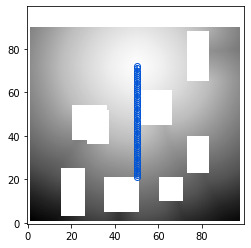

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  -0.15004897117614752 vy:  0.7459323406219482 v:  0.760874332946485
vx:  0.00952541083097469 vy:  0.9999546408653258 v:  1.0000000086198007
vx:  0.007114280015230123 vy:  0.9999746680259705 v:  0.9999999748368922
vx:  0.007114280015230123 vy:  0.9999746680259705 v:  0.9999999748368922
vx:  0.007114280015230123 vy:  0.9999746680259705 v:  0.9999999748368922
vx:  0.007114280015230123 vy:  0.9999746680259705 v:  0.9999999748368922
vx:  0.007114280015230123 vy:  0.9999746680259705 v:  0.9999999748368922
vx:  0.0053134337067604065 vy:  0.9999858736991882 v:  0.9999999900878425
vx:  0.0053134337067604065 vy:  0.9999858736991882 v:  0.9999999900878425
vx:  0.0053134337067604065 vy:  0.9999858736991882 v:  0.9999999900878425
vx:  0.0053134337067604065 vy:  0.9999858736991882 v:  0.9999999900878425
vx:  0.0053134337067604065 vy:  0.9999858736991882 v:  0.9999999900878425
vx:  0.0053134337067604065 vy:  0.9999858736991882 v:  0.9999999900878425
vx:  0.00954

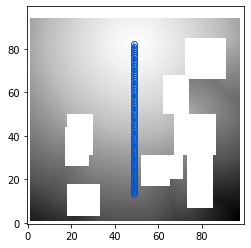

vx:  -0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -0.23462487757205958 vy:  0.5455218553543092 v:  0.5938374591122657
vx:  -0.07347562909126283 vy:  0.7954072356224059 v:  0.7987936770849118
vx:  -0.011569770053029088 vy:  0.9249973297119141 v:  0.9250696836202402
vx:  0.022651502862572587 vy:  0.9785122871398926 v:  0.9787744309419186
vx:  0.016301810741424644 vy:  0.9786386489868164 v:  0.9787744144204988
vx:  0.016301810741424644 vy:  0.9786386489868164 v:  0.9787744144204988
vx:  0.020073978230357115 vy:  0.9785685539245605 v:  0.978774427195561
vx:  0.051466621458530495 vy:  0.9734234213829039 v:  0.9747830376146039
vx:  0.07000549882650385 vy:  0.9547911882400513 v:  0.9573541575648986
vx:  0.07326728850603097 vy:  0.9246886372566223 v:  0.927586746044021
vx:  0.050860937684774316 vy:  0.8895656466484069 v:  0.8910184480015959
vx:  0.04888430237770083 vy:  0.8892083168029785 v:  0.890551012402176
vx:  0.07311579585075376 vy:  0.8530662655830384 v:  0.8561938875504077
vx:  0.104502119123935

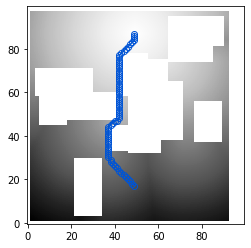

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  -0.2989963889122009 vy:  0.5957601070404053 v:  0.6665800369973071
vx:  -0.49170172214508046 vy:  0.6544092297554016 v:  0.8185487301007167
vx:  -0.4129691720008851 vy:  0.7067379355430603 v:  0.8185487441556327
vx:  -0.4129691720008851 vy:  0.7067379355430603 v:  0.8185487441556327
vx:  -0.4129691720008851 vy:  0.7067379355430603 v:  0.8185487441556327
vx:  -0.4129691720008851 vy:  0.7067379355430603 v:  0.8185487441556327
vx:  -0.3821516036987306 vy:  0.7238661646842955 v:  0.8185487600529753
vx:  -0.38215166330337536 vy:  0.7238661050796509 v:  0.8185487351701917
vx:  -0.38215166330337536 vy:  0.7238661050796509 v:  0.8185487351701917
vx:  -0.38215166330337536 vy:  0.7238661050796509 v:  0.8185487351701917
vx:  -0.3821516036987304 vy:  0.7238661050796509 v:  0.8185487073428775
vx:  -0.38215166330337536 vy:  0.7238661050796509 v:  0.8185487351701917
vx:  -0.38215166330337536 vy:  0.7238661050796509 v:  0.8185487351701917
vx:  -0.382151603698730

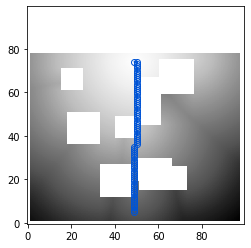

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  -0.12754109501838684 vy:  0.2502109110355377 v:  0.28084200348189187
vx:  -0.04044032841920855 vy:  0.3492230474948882 v:  0.351556762222362
vx:  0.08277009427547445 vy:  0.4169334471225739 v:  0.42506986230016713
vx:  0.11758768558502192 vy:  0.4783245027065277 v:  0.4925659282681751
vx:  0.11778977513313299 vy:  0.490534782409668 v:  0.5044787447253
vx:  0.11307819187641133 vy:  0.4850298166275025 v:  0.4980367461299891
vx:  0.10855506360530849 vy:  0.4722251296043396 v:  0.48454181952044956
vx:  0.10421285033226019 vy:  0.4560085833072661 v:  0.4677650545137739
vx:  0.10004433989524844 vy:  0.4384053945541382 v:  0.4496756163271982
vx:  0.09604257345199602 vy:  0.42046248912811274 v:  0.4312921059781762
vx:  0.09220087528228756 vy:  0.4027140140533447 v:  0.4131338506074968
vx:  0.08851283788681029 vy:  0.3854246735572815 v:  0.3954575849032533
vx:  0.08497232198715207 vy:  0.3687184154987335 v:  0.37838282919787064
vx:  0.0815734267234803 vy:

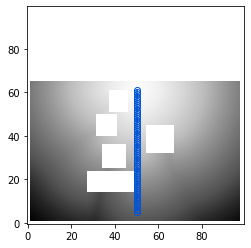

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  0.12757508456707 vy:  0.4399369359016418 v:  0.45806103280329397
vx:  -0.03642727434635157 vy:  0.5488390326499939 v:  0.5500465708251306
vx:  -0.03649652749300003 vy:  0.6379029750823975 v:  0.6389461652893936
vx:  -0.02124155871570116 vy:  0.8577337861061097 v:  0.8579967666865618
vx:  -0.001720145577564891 vy:  0.8579951524734498 v:  0.8579968767826294
vx:  -0.001720145577564891 vy:  0.8579951524734498 v:  0.8579968767826294
vx:  -0.001720145577564891 vy:  0.8579951524734498 v:  0.8579968767826294
vx:  -0.00126962317153817 vy:  0.857995867729187 v:  0.8579968070939182
vx:  -0.041841242462396566 vy:  0.8569759130477905 v:  0.8579967395712476
vx:  0.03234311938285844 vy:  0.8554693460464478 v:  0.856080533242376
vx:  0.03150229901075363 vy:  0.845787525177002 v:  0.8463739909685319
vx:  0.0290201678872109 vy:  0.8188166618347168 v:  0.8193307609521022
vx:  0.031246971338987295 vy:  0.7900145649909974 v:  0.7906322698421653
vx:  0.0361014716327191

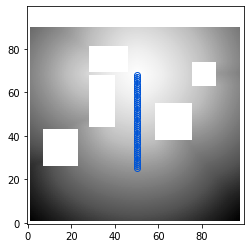

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  0.13647633790969832 vy:  0.7141183614730835 v:  0.7270425193908838
vx:  0.21958911418914784 vy:  0.918297052383423 v:  0.9441868752987714
vx:  0.17441196739673598 vy:  0.927938222885132 v:  0.9441868882072113
vx:  0.14693151414394356 vy:  0.9326843023300171 v:  0.9441868870416823
vx:  0.13295064866542805 vy:  0.934779703617096 v:  0.9441869355562085
vx:  0.12572355568408983 vy:  0.9357790350914001 v:  0.9441868538432646
vx:  0.12195356935262713 vy:  0.9362778067588806 v:  0.9441868483023187
vx:  0.11997532844543468 vy:  0.9365333914756775 v:  0.9441868844590696
vx:  0.11893269419670127 vy:  0.9366663694381713 v:  0.9441868847772514
vx:  0.11838074773550034 vy:  0.9367362856864929 v:  0.9441868831731052
vx:  0.11808757483959242 vy:  0.9367732405662537 v:  0.9441868350980628
vx:  0.11793081462383292 vy:  0.936793029308319 v:  0.9441868759935703
vx:  0.11613945662975311 vy:  0.9370168447494507 v:  0.9441869204402645
vx:  0.11519552767276742 vy:  0.93

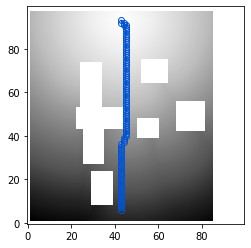

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  0.1690387278795243 vy:  0.5819383263587952 v:  0.6059920025944265
vx:  0.03260155022144319 vy:  0.8620394468307496 v:  0.8626557070866141
vx:  -0.009613163769245148 vy:  0.8846549987792969 v:  0.8847072282867661
vx:  -0.009613163769245148 vy:  0.8846549987792969 v:  0.8847072282867661
vx:  -0.009613163769245148 vy:  0.8846549987792969 v:  0.8847072282867661
vx:  -0.009613163769245148 vy:  0.8846549987792969 v:  0.8847072282867661
vx:  -0.009613163769245148 vy:  0.8846549987792969 v:  0.8847072282867661
vx:  -0.007101126480847611 vy:  0.8846787214279176 v:  0.8847072205790072
vx:  -0.007101126480847611 vy:  0.8846787214279176 v:  0.8847072205790072
vx:  -0.007101126480847611 vy:  0.8846787214279176 v:  0.8847072205790072
vx:  -0.007101126480847611 vy:  0.8846787214279176 v:  0.8847072205790072
vx:  -0.007101126480847611 vy:  0.8846787214279176 v:  0.8847072205790072
vx:  -0.04498934745788564 vy:  0.8828578591346742 v:  0.8840034167470998
vx:  -0.10

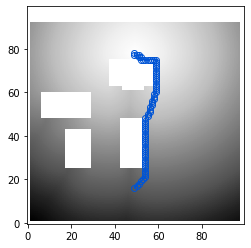

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  0.012119084596633911 vy:  0.41658911108970637 v:  0.416765353274444
vx:  -0.0006580650806426863 vy:  0.39992555975913996 v:  0.39992610117159366
vx:  -0.0006361454725265225 vy:  0.38392850756645197 v:  0.3839290345926775
vx:  -0.0006139129400253018 vy:  0.3685712814331054 v:  0.3685717927166149
vx:  -0.0005914717912673534 vy:  0.3538284301757812 v:  0.35382892453774545
vx:  -0.0005688667297363142 vy:  0.339675337076187 v:  0.33967581342682834
vx:  -0.0005462020635605136 vy:  0.32608833909034723 v:  0.3260887965376847
vx:  -0.0005235373973846644 vy:  0.3130447566509247 v:  0.3130451944337161
vx:  -0.0005009621381759505 vy:  0.30052301287651056 v:  0.30052343042005764
vx:  -0.00047853589057923057 vy:  0.288502037525177 v:  0.28850243439662204
vx:  -0.0003441870212554862 vy:  0.27696201205253596 v:  0.27696222591699154
vx:  -0.00033177435398103194 vy:  0.2658835649490356 v:  0.2658837719459952
vx:  -0.00031948089599610763 vy:  0.2552481889724731 v:  

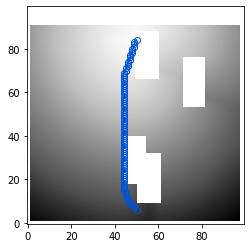

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -0.49577152729034424 vy:  0.5175414085388184 v:  0.7166857866765216
vx:  -0.31730508804321267 vy:  0.9434270262718202 v:  0.9953577612086022
vx:  -0.3171457648277283 vy:  0.94295334815979 v:  0.9948580064280143
vx:  -0.3169593811035154 vy:  0.9423993825912477 v:  0.994273526539799
vx:  -0.3167397081851959 vy:  0.9417461156845093 v:  0.9935843140610183
vx:  -0.316478133201599 vy:  0.9409685134887696 v:  0.9927638954817172
vx:  -0.31378841400146484 vy:  0.9329711198806764 v:  0.984326307325451
vx:  -0.3132600188255311 vy:  0.9314001798629762 v:  0.9826688834207362
vx:  -0.3126452565193174 vy:  0.9295722246170045 v:  0.980740320983815
vx:  -0.3107795715332031 vy:  0.9240249395370483 v:  0.974887701722002
vx:  -0.300274074077606 vy:  0.8927895426750184 v:  0.9419329525359181
vx:  -0.28770685195922846 vy:  0.8554241657257081 v:  0.9025107954876845
vx:  -0.2746859788894653 vy:  0.8167098760604858 v:  0.8616654853556558
vx:  -0.2679153084754946 vy:  0.79

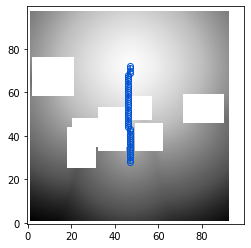

vx:  -0.0 vy:  0.0 v:  0.0
idx:  0
vx:  0.010974809527397128 vy:  0.3561732769012452 v:  0.35634232084153816
vx:  0.04256683215498917 vy:  0.5891116857528687 v:  0.5906475374453851
vx:  0.09946923702955252 vy:  0.6662417054176332 v:  0.6736261122856192
vx:  0.1186331063508988 vy:  0.7142792940139769 v:  0.7240640329277301
vx:  0.10157289355993265 vy:  0.6857081651687623 v:  0.6931902628321088
vx:  0.08954150229692459 vy:  0.6582798361778259 v:  0.6643417970833203
vx:  0.08025229722261427 vy:  0.6319486498832703 v:  0.6370239613223312
vx:  0.07251196354627604 vy:  0.6066706776618959 v:  0.610988785487983
vx:  0.06652353703975679 vy:  0.5824038982391359 v:  0.586190823592814
vx:  0.06260687857866283 vy:  0.5591077208518983 v:  0.5626020483090758
vx:  0.059455037117004395 vy:  0.5367434024810792 v:  0.5400262785694323
vx:  0.05689160153269769 vy:  0.5152736306190491 v:  0.5184048309345617
vx:  0.05461866036057471 vy:  0.49466270208358765 v:  0.4976689531126289
vx:  0.052548475563526126 vy

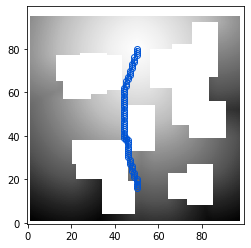

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  0.05295148119330402 vy:  0.2766712009906768 v:  0.2816927631626136
vx:  0.23304447531700137 vy:  0.5750666856765747 v:  0.6204928850928243
vx:  0.09211492538452157 vy:  0.6370365023612976 v:  0.6436619181055467
vx:  -0.02007225155830389 vy:  0.6185065507888793 v:  0.618832165171928
vx:  -0.01965225115418437 vy:  0.5937663316726685 v:  0.5940914640048656
vx:  -0.019199583679437665 vy:  0.5700156688690184 v:  0.5703389227202175
vx:  -0.018715808168053766 vy:  0.5472150444984437 v:  0.5475350092923895
vx:  -0.018202718347310992 vy:  0.5253264904022216 v:  0.5256417605875192
vx:  -0.017662342637777356 vy:  0.5043134093284607 v:  0.5046226047017214
vx:  -0.017096921801567105 vy:  0.4841407835483551 v:  0.48444256938248537
vx:  -0.016508903354406357 vy:  0.46477517485618586 v:  0.46506828213990603
vx:  -0.015900911763310308 vy:  0.4461841881275177 v:  0.446467433000344
vx:  -0.01527574099600311 vy:  0.4283368289470672 v:  0.42860913113862387
vx:  -0.01

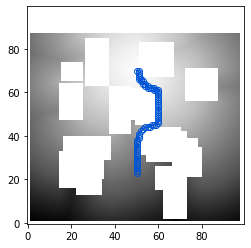

vx:  -0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -0.1523464471101761 vy:  0.13364122807979584 v:  0.2026559098318371
idx:  0
vx:  -0.44528609514236456 vy:  0.28569963574409485 v:  0.5290595319918576
vx:  -0.4775951802730561 vy:  0.3294517397880554 v:  0.5802030722681754
vx:  -0.44238361716270436 vy:  0.3360901772975923 v:  0.5555716623531883
vx:  -0.4246476292610169 vy:  0.33860138058662415 v:  0.5431173942824608
vx:  -0.40683966875076294 vy:  0.32792627811431885 v:  0.5225458448281262
vx:  -0.39035725593566895 vy:  0.35395020246505743 v:  0.5269340879907851
vx:  -0.37474298477172846 vy:  0.49685621261596685 v:  0.6223330303388265
vx:  -0.3597532510757448 vy:  0.6302597522735595 v:  0.7257063848385905
vx:  -0.4309939444065093 vy:  0.7462474703788757 v:  0.8617662485627714
vx:  -0.41588771343231185 vy:  0.7732843756675721 v:  0.8780269448231891
vx:  -0.4116372764110564 vy:  0.7693831920623782 v:  0.8725799353407152
vx:  -0.41203162074089045 vy:  0.7494967579841614 v:  0.8552867628574252
vx:  -0.

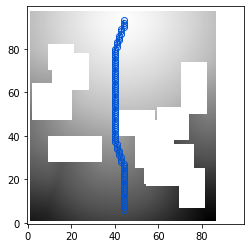

vx:  -0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -0.04544665664434436 vy:  0.6079922318458556 v:  0.6096884061428867
vx:  -0.002088068053126252 vy:  0.9369862675666808 v:  0.9369885941871086
vx:  0.0024422262795270183 vy:  0.9481771588325502 v:  0.9481803040566533
vx:  0.0024422262795270183 vy:  0.9481771588325502 v:  0.9481803040566533
vx:  0.0024422262795270183 vy:  0.9481771588325502 v:  0.9481803040566533
vx:  0.0024422262795270183 vy:  0.9481771588325502 v:  0.9481803040566533
vx:  0.0018211862770840803 vy:  0.9481784701347351 v:  0.9481802191284643
vx:  0.0018211862770840803 vy:  0.9481784701347351 v:  0.9481802191284643
vx:  0.0018211862770840803 vy:  0.9481784701347351 v:  0.9481802191284643
vx:  0.0018211863934993328 vy:  0.9481784701347351 v:  0.9481802191286879
vx:  0.0018211863934993328 vy:  0.9481784701347351 v:  0.9481802191286879
vx:  0.0018211863934993328 vy:  0.9481784701347351 v:  0.9481802191286879
vx:  0.0013412520056589883 vy:  0.9481792449951172 v:  0.9481801936322299
vx: 

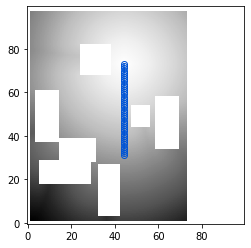

vx:  -0.0 vy:  0.0 v:  0.0
idx:  0
vx:  0.1731633096933365 vy:  0.42742758989334106 v:  0.4611722849716584
vx:  0.12288679927587513 vy:  0.5424498915672302 v:  0.5561951548670386
vx:  -0.026874884963035625 vy:  0.5897083282470703 v:  0.590320397619573
vx:  -0.09617626667022702 vy:  0.6705363392829895 v:  0.6773985950455279
vx:  -0.17749136686325068 vy:  0.7347561120986938 v:  0.7558900247902293
vx:  -0.17427574098110196 vy:  0.7240735292434691 v:  0.7447513072466574
vx:  -0.17412054538726807 vy:  0.7069608569145203 v:  0.7280876441303427
vx:  -0.17460310459136968 vy:  0.6869496107101439 v:  0.7087919382920231
vx:  -0.17488658428192136 vy:  0.6651566624641418 v:  0.6877635516529165
vx:  -0.17665153741836545 vy:  0.6438757181167604 v:  0.6676688595798415
vx:  -0.18296052515506742 vy:  0.6254097819328308 v:  0.6516225511001664
vx:  -0.1908209472894669 vy:  0.607690155506134 v:  0.6369458054053884
vx:  -0.19954583048820496 vy:  0.5902319550514222 v:  0.6230507998783498
vx:  -0.208741724491

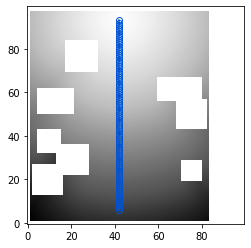

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -0.00494691682979434 vy:  0.5869569182395936 v:  0.5869777643620258
vx:  0.00020700496679615377 vy:  0.8123435378074646 v:  0.8123435641824239
vx:  0.00020700496679615377 vy:  0.8123435378074646 v:  0.8123435641824239
vx:  0.00020700496679615377 vy:  0.8123435378074646 v:  0.8123435641824239
vx:  0.00020700496679615377 vy:  0.8123435378074646 v:  0.8123435641824239
vx:  0.00020700496679615377 vy:  0.8123435378074646 v:  0.8123435641824239
vx:  0.00020700496679615377 vy:  0.8123435378074646 v:  0.8123435641824239
vx:  0.000154032648424951 vy:  0.8123435378074646 v:  0.8123435524109269
vx:  0.000154032648424951 vy:  0.8123435378074646 v:  0.8123435524109269
vx:  0.000154032648424951 vy:  0.8123435378074646 v:  0.8123435524109269
vx:  0.000154032648424951 vy:  0.8123435378074646 v:  0.8123435524109269
vx:  0.000154032648424951 vy:  0.8123435378074646 v:  0.8123435524109269
vx:  0.000154032648424951 vy:  0.8123435378074646 v:  0.8123435524109269
vx:  

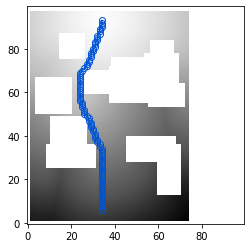

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  0.13450664281845098 vy:  0.4173378050327301 v:  0.4384779133226979
vx:  0.17053152620792408 vy:  0.7039502263069152 v:  0.7243113436557245
vx:  0.08524917811155322 vy:  0.836028516292572 v:  0.8403636727173865
vx:  0.09080526977777478 vy:  0.8656800985336303 v:  0.8704295663731846
vx:  0.12350437045097329 vy:  0.8616230487823487 v:  0.87042955356162
vx:  0.15603172779083255 vy:  0.8404024243354798 v:  0.8547643739103452
vx:  0.0798122808337211 vy:  0.7620744109153748 v:  0.7662423950316872
vx:  -0.00699680298566796 vy:  0.8084279894828796 v:  0.8084582669695147
vx:  -0.050599869340658216 vy:  0.8345398306846618 v:  0.8360724106059687
vx:  -0.06756688654422763 vy:  0.844571590423584 v:  0.8472700015390033
vx:  -0.0632255822420118 vy:  0.8431363701820374 v:  0.8455036445655234
vx:  -0.0545119196176527 vy:  0.8383769989013672 v:  0.8401473333096192
vx:  -0.047797102481126924 vy:  0.8335492610931396 v:  0.8349185191828664
vx:  -0.045549292117357365 vy

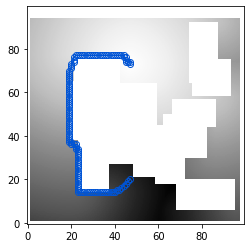

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  -0.095646932721138 vy:  -0.25120532512664795 v:  0.26879816054234223
vx:  -0.5016396045684817 vy:  -0.3420870900154111 v:  0.60717861459939
vx:  -0.7431485056877135 vy:  -0.41893115639686596 v:  0.8530961348557952
vx:  -0.7394933700561523 vy:  -0.3899810314178463 v:  0.8360237133136432
vx:  -0.7295743227005005 vy:  -0.37495714426040655 v:  0.8202874815427902
vx:  -0.7161675095558167 vy:  -0.36097732186317444 v:  0.8019978358093559
vx:  -0.7077476978302002 vy:  -0.3388717770576478 v:  0.784691585956009
vx:  -0.6986575126647948 vy:  -0.31574994325637834 v:  0.7666944284846239
vx:  -0.6918566226959227 vy:  -0.2905790209770203 v:  0.7504010619663142
vx:  -0.7052116990089418 vy:  -0.2587710320949551 v:  0.7511897146996667
vx:  -0.8406645059585571 vy:  -0.14688028395175964 v:  0.8533994547644699
vx:  -0.8406644463539124 vy:  -0.14688026905059837 v:  0.8533993934846135
vx:  -0.8406645655632019 vy:  -0.1468803435564035 v:  0.8533995237383333
vx:  -0.8406

vx:  0.8533993363380431 vy:  -0.0005485257715918124 v:  0.8533995126215708
vx:  0.8533993363380432 vy:  -0.000548577110748627 v:  0.8533995126545708
vx:  0.8429982066154479 vy:  -0.0005419568624346893 v:  0.8429983808253145


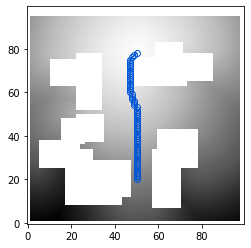

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  -0.0008598067215644101 vy:  0.46284398436546326 v:  0.4628447829790195
vx:  -0.058828957378864316 vy:  0.6502087116241455 v:  0.6528646221830491
vx:  -0.1281750202178955 vy:  0.7822012305259705 v:  0.7926333331649636
vx:  -0.12567499279975897 vy:  0.8933252692222594 v:  0.9021220762436987
vx:  -0.0956606119871139 vy:  0.8970358967781068 v:  0.9021221385124364
vx:  -0.07974804937839511 vy:  0.8985902667045592 v:  0.9021220642439857
vx:  -0.07134459167718898 vy:  0.8992965221405029 v:  0.9021221012122411
vx:  -0.06691027432680136 vy:  0.8996372818946838 v:  0.9021220670094168
vx:  -0.06456833332777023 vy:  0.8998084068298341 v:  0.9021220752594242
vx:  -0.06332872062921518 vy:  0.8998965024948119 v:  0.902122077137528
vx:  -0.06267078965902334 vy:  0.8999425768852234 v:  0.9021220923840086
vx:  -0.06232041120529169 vy:  0.8999668955802919 v:  0.9021220797615058
vx:  -0.062133014202117975 vy:  0.899979829788208 v:  0.9021220568634005
vx:  -0.0754829

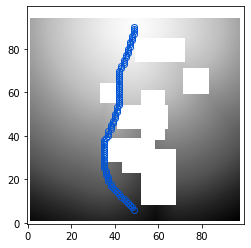

vx:  -0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -0.2412261515855789 vy:  0.38224661350250244 v:  0.4519983736064989
vx:  -0.5302090644836425 vy:  0.7242399454116821 v:  0.8975773786089618
vx:  -0.46039620041847223 vy:  0.8877135515213013 v:  1.000000005457164
vx:  -0.46039620041847223 vy:  0.8877135515213013 v:  1.000000005457164
vx:  -0.46955272555351246 vy:  0.8794286251068116 v:  0.9969325296789092
vx:  -0.47320431470870983 vy:  0.8808207511901853 v:  0.9998837528363895
vx:  -0.5402820110321045 vy:  0.8414840102195739 v:  0.9999999954500555
vx:  -0.5402820110321045 vy:  0.8414840102195739 v:  0.9999999954500555
vx:  -0.5402820110321045 vy:  0.8414840102195739 v:  0.9999999954500555
vx:  -0.5402820110321045 vy:  0.8414840102195739 v:  0.9999999954500555
vx:  -0.5402820110321045 vy:  0.8414840102195739 v:  0.9999999954500555
vx:  -0.45450645685195934 vy:  0.8904504776000977 v:  0.9997390521422898
vx:  -0.45449501276016224 vy:  0.8904280662536621 v:  0.9997138879680006
vx:  -0.4544818699359892

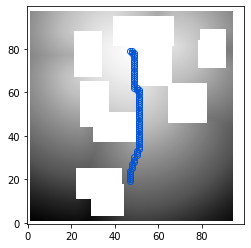

vx:  -0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -0.0764139890670776 vy:  0.40614604949951166 v:  0.4132719579758627
vx:  -0.036449536681175176 vy:  0.6352040171623231 v:  0.6362489388151663
vx:  0.007726103067398099 vy:  0.609795868396759 v:  0.6098448112285334
vx:  0.007510781288147028 vy:  0.5854040384292603 v:  0.5854522184131213
vx:  0.007278621196746882 vy:  0.5619877576828003 v:  0.5620348904755537
vx:  0.007030576467514038 vy:  0.5395083427429198 v:  0.5395541501042109
vx:  0.004812955856323187 vy:  0.5179280042648314 v:  0.5179503664887459
vx:  0.004674792289733873 vy:  0.497210830450058 v:  0.49723280623847466
vx:  0.004530549049377469 vy:  0.47732236981391907 v:  0.47734387039058596
vx:  0.004380851984024048 vy:  0.45822951197624207 v:  0.4582504528203883
vx:  0.0042263567447662215 vy:  0.4399003684520722 v:  0.4399206704118402
vx:  0.004067689180374159 vy:  0.4223043024539948 v:  0.42232389225146055
vx:  0.003905624151229886 vy:  0.40541210770606995 v:  0.4054309201019191
vx:  0.003

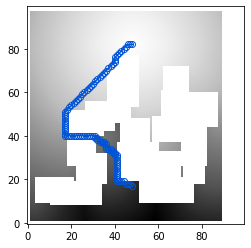

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  -0.28449657559394836 vy:  0.10006409883499151 v:  0.3015810428398014
vx:  -0.4252797365188599 vy:  0.2756195664405822 v:  0.5067829907351326
vx:  -0.42709219455718994 vy:  0.2767942845821381 v:  0.5089428441672151
vx:  -0.4100085496902467 vy:  0.26572254300117487 v:  0.4885851826223455
vx:  -0.39360821247100836 vy:  0.25509363412857045 v:  0.469041775428952
vx:  -0.37786385416984564 vy:  0.2448898553848266 v:  0.45028006124909825
vx:  -0.362749308347702 vy:  0.23509438335895538 v:  0.43226893225590907
vx:  -0.34823936223983765 vy:  0.22569054365158076 v:  0.41497816196392184
vx:  -0.3343097567558288 vy:  0.21666255593299866 v:  0.3983788104374543
vx:  -0.32093736529350275 vy:  0.20799598097801214 v:  0.38244361747130884
vx:  -0.30809986591339117 vy:  0.19967694580554962 v:  0.3671463060716831
vx:  -0.2957758605480194 vy:  0.19168917834758759 v:  0.35246006976463967
vx:  -0.28394484519958496 vy:  0.184023067355156 v:  0.3383624749203383
vx:  -0.27

vx:  -0.005898445844650268 vy:  0.018316760659217834 v:  0.0192430606824731
idx:  0
vx:  -0.005662500858306886 vy:  0.01758407056331635 v:  0.018473317340045203
idx:  0
vx:  -0.005436003208160401 vy:  0.016880713403224945 v:  0.017734390767121053
idx:  0
vx:  -0.0052185654640197815 vy:  0.01620548963546753 v:  0.017025020406081913
idx:  0
vx:  -0.005009859800338745 vy:  0.015557274222373964 v:  0.016344034888888106
idx:  0
vx:  -0.004809439182281494 vy:  0.014934979379177097 v:  0.015690261766602546
idx:  0
vx:  -0.004617080092430116 vy:  0.014337576925754547 v:  0.01506265383927559
idx:  0
vx:  -0.004432365298271181 vy:  0.01376408338546753 v:  0.014460147080144859
idx:  0
vx:  -0.004255071282386781 vy:  0.013213500380516054 v:  0.013881722656936012
idx:  0
vx:  -0.004084885120391846 vy:  0.012684978544712067 v:  0.013326476170638814
idx:  0
vx:  -0.003921478986740114 vy:  0.012177571654319763 v:  0.012793406459560973
idx:  0
vx:  -0.0037646442651748666 vy:  0.01169046014547348 v:  0.

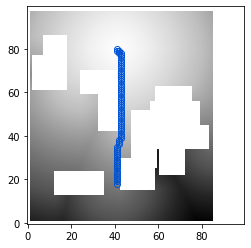

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  -0.02751907519996158 vy:  0.44140860438346863 v:  0.44226559387275727
vx:  -0.06108985096216191 vy:  0.7396236658096313 v:  0.7421422619122673
vx:  -0.011731121689081192 vy:  0.932810366153717 v:  0.9328841291499795
vx:  0.006786942481994518 vy:  0.9507930278778076 v:  0.9508172508160038
vx:  0.03384365141391765 vy:  0.9239251017570496 v:  0.9245447454816891
vx:  0.07915909588336972 vy:  0.9388799667358398 v:  0.9422110986392404
vx:  0.0753666758537293 vy:  0.9941991567611694 v:  0.997051703340334
vx:  0.07533803582191484 vy:  0.9938214421272278 v:  0.9966729044542882
vx:  0.07518564164638519 vy:  0.9918109774589537 v:  0.9946566722833884
vx:  0.07305929064750694 vy:  0.9637612104415894 v:  0.9665264252475223
vx:  0.07007960975170152 vy:  0.924454927444458 v:  0.9271073641058456
vx:  0.06681735813617701 vy:  0.8814208507537843 v:  0.8839498150301425
vx:  0.06353960931301128 vy:  0.838182508945465 v:  0.8405874138087986
vx:  0.06036558002233511 vy

vx:  -1.7954833310754315e-05 vy:  0.15373261272907257 v:  0.1537326137775685
idx:  0
vx:  -1.760491795721464e-05 vy:  0.15077920258045197 v:  0.15077920360822347
idx:  0
vx:  -1.781556056815181e-05 vy:  0.15253715217113495 v:  0.1525371532115182
idx:  0
vx:  -1.8212842405801455e-05 vy:  0.15598063170909884 v:  0.15598063277239632
idx:  0
vx:  -1.8578808521851897e-05 vy:  0.15912181138992312 v:  0.15912181247453913
idx:  0
vx:  -1.883844379335642e-05 vy:  0.16131374239921567 v:  0.16131374349920552
idx:  0
vx:  -1.9008817616864015e-05 vy:  0.16284267604351044 v:  0.16284267715297127
idx:  0
vx:  -1.9130849977996855e-05 vy:  0.16394443809986115 v:  0.1639444392160607
idx:  0
vx:  -1.9243147107841918e-05 vy:  0.16479149460792542 v:  0.1647914957314625
idx:  0
vx:  -1.9334402168141862e-05 vy:  0.16551253199577332 v:  0.16551253312505065
idx:  0
vx:  -2.1388288587373405e-05 vy:  0.18309646844863892 v:  0.18309646969786805
idx:  0
vx:  -2.7129426598521134e-05 vy:  0.23238731920719147 v:  0.2

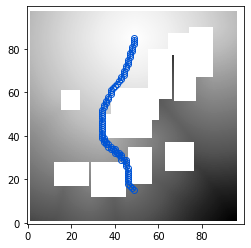

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  1.3877787807814457e-17 vy:  0.15576077997684482 v:  0.15576077997684482
idx:  0
vx:  -0.2013534009456635 vy:  0.14953033626079554 v:  0.25080373508911646
vx:  -0.19329926371574402 vy:  0.5152675509452819 v:  0.550331949290787
vx:  -0.29181212186813366 vy:  0.7778682112693788 v:  0.8308027856071533
vx:  -0.337936043739319 vy:  0.9008177518844604 v:  0.9621192191035144
vx:  -0.34994682669639576 vy:  0.9328348636627197 v:  0.9963150427347377
vx:  -0.3389335870742798 vy:  0.903477668762207 v:  0.9649600377212678
vx:  -0.3253761827945708 vy:  0.8673385381698608 v:  0.9263615925353323
vx:  -0.3123927116394044 vy:  0.8326449394226074 v:  0.8893181665925293
vx:  -0.24112544953823095 vy:  0.7993391752243041 v:  0.8349159235894861
vx:  -0.1599238216876984 vy:  0.7673656940460205 v:  0.7838531349314931
vx:  -0.15749268233776087 vy:  0.7366709709167482 v:  0.7533180366759894
vx:  -0.15460653603076938 vy:  0.7072042226791383 v:  0.7239067575030902
vx:  -0.3479

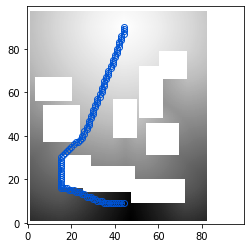

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -0.2813583314418793 vy:  0.23474881052970886 v:  0.36642804848547217
vx:  -0.43739742040634155 vy:  0.18009345233440402 v:  0.47302236199977493
vx:  -0.5868418216705322 vy:  0.07443131506443014 v:  0.5915431888914022
vx:  -0.8827365636825562 vy:  0.06121011078357694 v:  0.8848562134743844
vx:  -0.9692409038543701 vy:  0.15295074880123127 v:  0.9812348654951544
vx:  -0.9612529277801515 vy:  0.19177703559398646 v:  0.9801967264519558
vx:  -0.9558635950088501 vy:  0.21058991551399242 v:  0.978786659481745
vx:  -0.9715802669525146 vy:  0.22197997570037833 v:  0.9966159364286025
vx:  -0.9708180427551271 vy:  0.22502511739730846 v:  0.9965560574290682
vx:  -0.9704848527908324 vy:  0.2251226902008058 v:  0.9962535195118217
vx:  -0.8787885904312136 vy:  0.20897729694843287 v:  0.9032944687708172
vx:  -0.8684425950050354 vy:  0.20507676899433142 v:  0.8923278668741856
vx:  -0.9267957806587218 vy:  0.2117256820201875 v:  0.9506724901214524
vx:  -0.922348737

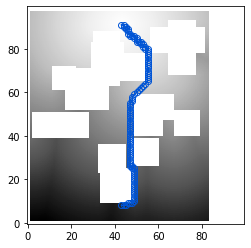

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  0.30994272232055664 vy:  0.10577333718538282 v:  0.327494259459323
vx:  0.5546213388442993 vy:  0.3359753787517548 v:  0.648447595900261
vx:  0.6226969361305237 vy:  0.3772135972976685 v:  0.7280395403084843
vx:  0.6027581095695496 vy:  0.3651350736618042 v:  0.7047275790472999
vx:  0.5813996195793152 vy:  0.3521965742111206 v:  0.6797557977193146
vx:  0.5586854815483093 vy:  0.3384369015693664 v:  0.6531990536098007
vx:  0.5347256660461425 vy:  0.3239232003688811 v:  0.6251861943978841
vx:  0.5096777677536011 vy:  0.30874916911125183 v:  0.5959005591280999
vx:  0.48374712467193604 vy:  0.2930421829223633 v:  0.5655837706301954
vx:  0.4571744203567505 vy:  0.2769444584846496 v:  0.5345153727573105
vx:  0.48493969440460216 vy:  0.4064604640007019 v:  0.6327532030775466
vx:  0.29570314288139343 vy:  0.39733564853668213 v:  0.49529381816049306
vx:  0.15916314721107483 vy:  0.3701738715171814 v:  0.4029411899820531
vx:  0.04280441626906395 vy:  0.3793

vx:  0.2376214414834976 vy:  0.5997211337089539 v:  0.6450809155988481
vx:  0.23320402204990384 vy:  0.5885722041130066 v:  0.6330887420849424
vx:  0.2289537638425827 vy:  0.5778453946113585 v:  0.6215505820536587
vx:  0.22488228976726538 vy:  0.5675692558288573 v:  0.6104972599554327
vx:  0.21675583720207217 vy:  0.5470592975616455 v:  0.5884360356145876
vx:  0.2080855369567872 vy:  0.5251769423484802 v:  0.5648985851151456
vx:  0.1997621208429336 vy:  0.5041698813438416 v:  0.5423026592023407
vx:  0.19177192449569705 vy:  0.4840030968189239 v:  0.520610669075358
vx:  0.1841131746768951 vy:  0.4646739363670349 v:  0.49981949564661854
vx:  0.15546435117721563 vy:  0.4462827444076538 v:  0.47258592069906175
vx:  -0.0005091279745101096 vy:  0.4782913625240326 v:  0.4782916335003049


In [3]:
from navrep.envs.e2eenv import E2E1DNavRepEnv
env = E2E1DNavRepEnv(silent=True, scenario='train', adaptive=False, collect_statistics=False)
env.soadrl_sim.human_num = 5
#env.soadrl_sim.num_walls = 0
#env.soadrl_sim.num_circles = 0

data_reg = play_policy(env,10)

[[22 10]]


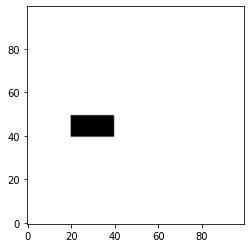

In [4]:
from map2d import gridshow

cmap2d = CMap2D.CMap2D()
cmap2d.set_resolution(0.1)
cmap2d.origin[0] = 0
cmap2d.origin[1] = 0
cmap2d._occupancy[20:40, 40:50] = 1.
coarse = cmap2d.as_coarse_map2d().as_coarse_map2d().as_coarse_map2d()

print(cmap2d.xy_to_ij([[2.26, 1.]]))

# occupancy
plt.figure("occupancy") 
grid = cmap2d.occupancy()
gridshow(grid)
plt.show()

In [5]:
env.reset()
i = 0
for vertex in env.soadrl_sim.obstacle_vertices:
    print(vertex)
    i+=1    
print(i)
env.render()

[(3.530640526219372, 1.230640526219372), (1.469359473780628, 1.230640526219372), (1.469359473780628, -0.8306405262193721), (3.530640526219372, -0.8306405262193721)]
[(5.177283011270025, -3.5227169887299765), (4.022716988729976, -3.5227169887299765), (4.022716988729976, -4.677283011270025), (5.177283011270025, -4.677283011270025)]
[(-4.227887884570115, -2.5278878845701147), (-6.772112115429885, -2.5278878845701147), (-6.772112115429885, -5.072112115429886), (-4.227887884570115, -5.072112115429886)]
[(2.5250000000000004, 2.075), (1.2750000000000001, 2.075), (1.2750000000000001, -1.675), (2.5250000000000004, -1.675)]
[(3.575, -5.9750000000000005), (-0.17499999999999982, -5.9750000000000005), (-0.17499999999999982, -7.2250000000000005), (3.575, -7.2250000000000005)]
[(0.125, -0.2250000000000001), (-1.125, -0.2250000000000001), (-1.125, -3.975), (0.125, -3.975)]
[(7.4750000000000005, 7.325), (3.7250000000000005, 7.325), (3.7250000000000005, 6.075), (7.4750000000000005, 6.075)]
[(3.825, -0.8

ArgumentError: argument 2: <class 'TypeError'>: wrong type

In [ ]:
i

In [ ]:
import numpy as np
np.array((1,2))

In [ ]:
amap = CMap2D.CMap2D()
print(dir(env.soadrl_sim.robot))

In [13]:
data = data_reg
print(data['rewards'][data['rewards']>2].size)
print(data['dones'][data['dones']==True].size)

77
95


In [ ]:
#177

#182

# 283 augmented

# 232 not augmented